In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session




/kaggle/input/predictemall/300k.csv
/kaggle/input/predictemall/300k.arff
/kaggle/input/predictemall/300k_arff/300k.arff
/kaggle/input/predictemall/300k_csv/300k.csv


In [2]:
#import pandas as pd
#import numpy as np
import random
import xgboost as xgb
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
#from rattle import fancyRpartPlot

In [3]:
poke = pd.read_csv('/kaggle/input/predictemall/300k.csv', low_memory=False, sep=',')

In [5]:
poke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296021 entries, 0 to 296020
Columns: 208 entries, pokemonId to class
dtypes: bool(168), float64(7), int64(17), object(9), uint64(7)
memory usage: 137.8+ MB


In [5]:
poke.head()

pokemonId   latitude   longitude    appearedLocalTime  \
0         16  20.525745  -97.460829  2016-09-08T03:57:45   
1        133  20.523695  -97.461167  2016-09-08T03:57:37   
2         16  38.903590  -77.199780  2016-09-08T03:57:25   
3         13  47.665903 -122.312561  2016-09-08T03:56:22   
4        133  47.666454 -122.311628  2016-09-08T03:56:08   

                            _id           cellId_90m          cellId_180m  \
0  NTgxMDkzOTk4MTM5MjUwMjIzNw==  9645139108510564000  9645139108711890000   
1  OTQ1NDgzODc1MjM3NDEzMTI2MQ==  9645139109852742000  9645139109785633000   
2  NTQ0OTQ0NDA1Nzg2ODg3OTg2OQ==  9923201472785285000  9923201472986612000   
3  NTU2MTU1NDM4NzA2MDk1MDcxNw==  6093392705025474600  6093392705092583400   
4  MTY2ODg4MTAzMTczMDE0MTUwNTM=  6093392707709829100  6093392707776938000   

           cellId_370m          cellId_730m         cellId_1460m  ...  \
0  9645139108443455000  9645139109517197000  9645139113812165000  ...   
1  9645139110590940000  9645139109517197000  9645139113812165000  ...   
2  9923201473791918000  9923201477013144000  9923201481308110000  ...   
3  6093392705897889800  6093392702676664300  6093392715561566200  ...   
4  6093392708045373400  6093392711266598900  6093392715561566200  ...   

   cooc_143  cooc_144 cooc_145  cooc_146  cooc_147 cooc_148  cooc_149  \
0     False     False    False     False     False    False     False   
1     False     False    False     False     False    False     False   
2     False     False    False     False     False    False     False   
3     False     False    False     False     False    False     False   
4     False     False    False     False     False    False     False   

   cooc_150  cooc_151  class  
0     False     False     16  
1     False     False    133  
2     False     False     16  
3     False     False     13  
4     False     False    133  

[5 rows x 208 columns]

In [7]:
poke.describe()

pokemonId       latitude      longitude    cellId_90m  \
count  296021.000000  296021.000000  296021.000000  2.960210e+05   
mean       45.318555      38.774278     -35.704107  7.078848e+18   
std        39.603926      17.029203      67.398336  2.578027e+18   
min         1.000000     -42.984504    -159.332033  4.317273e+16   
25%        16.000000      33.809355     -90.237842  5.143978e+18   
50%        21.000000      42.246942     -71.119739  6.025857e+18   
75%        69.000000      49.478332      12.568306  9.758153e+18   
max       149.000000      68.438473     175.616223  1.228088e+19   

        cellId_180m   cellId_370m   cellId_730m  cellId_1460m  cellId_2920m  \
count  2.960210e+05  2.960210e+05  2.960210e+05  2.960210e+05  2.960210e+05   
mean   7.078848e+18  7.078848e+18  7.078848e+18  7.078848e+18  7.078848e+18   
std    2.578027e+18  2.578027e+18  2.578027e+18  2.578027e+18  2.578027e+18   
min    4.317273e+16  4.317273e+16  4.317273e+16  4.317272e+16  4.317267e+16   
25%    5.143978e+18  5.143978e+18  5.143978e+18  5.143978e+18  5.143978e+18   
50%    6.025857e+18  6.025857e+18  6.025857e+18  6.025857e+18  6.025857e+18   
75%    9.758153e+18  9.758153e+18  9.758153e+18  9.758153e+18  9.758153e+18   
max    1.228088e+19  1.228088e+19  1.228088e+19  1.228088e+19  1.228088e+19   

       cellId_5850m  ...    sunriseHour  sunriseMinute  sunriseMinutesSince  \
count  2.960210e+05  ...  296021.000000  296021.000000        296021.000000   
mean   7.078848e+18  ...       6.174663      28.030349           485.730333   
std    2.578027e+18  ...       0.450417      15.031796           406.958716   
min    4.317260e+16  ...       4.000000       0.000000          -444.000000   
25%    5.143978e+18  ...       6.000000      16.000000           246.000000   
50%    6.025857e+18  ...       6.000000      26.000000           561.000000   
75%    9.758153e+18  ...       6.000000      41.000000           821.000000   
max    1.228088e+19  ...       8.000000      59.000000          1092.000000   

       sunsetMinutesMidnight     sunsetHour   sunsetMinute  \
count          296021.000000  296021.000000  296021.000000   
mean             1176.034285      19.045642      33.295763   
std                30.382728       0.517971      15.293694   
min              1043.000000      17.000000       0.000000   
25%              1164.000000      19.000000      21.000000   
50%              1181.000000      19.000000      36.000000   
75%              1192.000000      19.000000      45.000000   
max              1251.000000      20.000000      59.000000   

       sunsetMinutesBefore  population_density  gymDistanceKm          class  
count        296021.000000       296021.000000  296021.000000  296021.000000  
mean            291.793805         1313.648251       2.149072      45.318555  
std             408.572706         1913.710175      18.646146      39.603926  
min            -375.000000            0.000000       0.000591       1.000000  
25%             -49.000000          160.222840       0.183422      16.000000  
50%             223.000000          570.040200       0.334473      21.000000  
75%             537.000000         1691.790000       0.636140      69.000000  
max            1229.000000        10000.000000    3859.424664     149.000000  

[8 rows x 31 columns]

In [8]:
poke.isna().sum()

pokemonId            0
latitude             0
longitude            0
appearedLocalTime    0
_id                  0
                    ..
cooc_148             0
cooc_149             0
cooc_150             0
cooc_151             0
class                0
Length: 208, dtype: int64

In [9]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


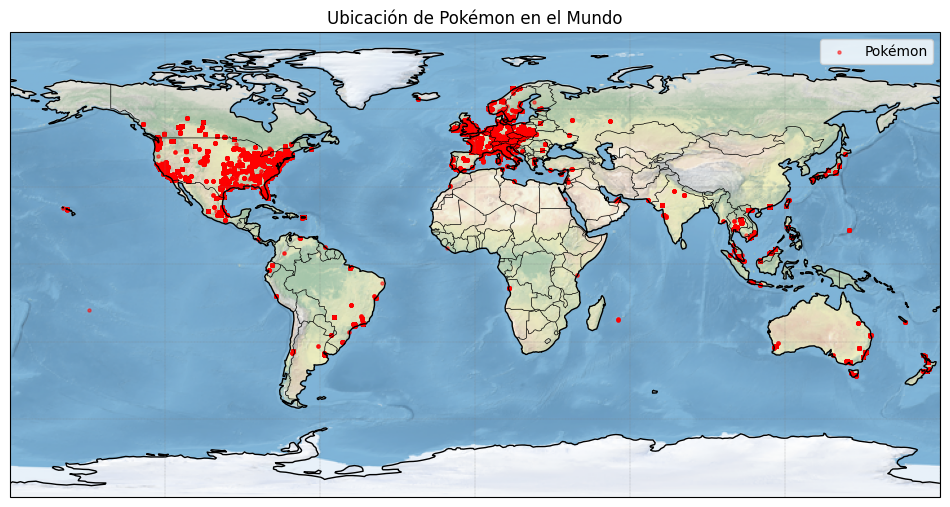

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Crea una figura y un objeto de mapa
plt.figure(figsize=(12, 9))
ax = plt.axes(projection=ccrs.PlateCarree())


ax.set_global()
ax.stock_img()
# Cambia el color de fondo para representar el mar y la tierra
#ax.background_patch.set_facecolor('lightblue')  # Color del mar
ax.add_feature(cfeature.LAND, edgecolor='gray')     # Características geográficas de la tierra


# Dibuja límites de países
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='solid', edgecolor='k')
ax.add_feature(cfeature.COASTLINE, linewidth=1.0, linestyle='solid', edgecolor='k')

# Dibuja líneas de latitud/longitud
ax.gridlines(linewidth=0.2, color='gray', linestyle='--', x_inline=False, y_inline=False)

# Convierte las coordenadas de latitud y longitud a coordenadas del mapa
x, y = poke['longitude'].values, poke['latitude'].values

# Agrega marcadores para cada Pokémon
ax.scatter(x, y, s=5, c='red', marker='o', alpha=0.5, label='Pokémon')

# Agrega un título
plt.title('Ubicación de Pokémon en el Mundo')

# Muestra el mapa
plt.legend()
plt.show()


In [4]:
poke = poke.drop(['_id'], axis=1)
# no tiene relevancia
poke = poke.drop(poke.filter(like="cell", axis=1), axis=1)
poke = poke.drop(poke.filter(like="sunset", axis=1), axis=1)
poke = poke.drop(poke.filter(like="sunrise", axis=1), axis=1)
poke = poke.drop(poke.filter(like="pokestopIn", axis=1), axis=1)
poke = poke.drop(poke.filter(like="gymIn", axis=1), axis=1)
poke = poke.drop(poke.filter(like="cooc", axis=1), axis=1)
# info repetida en otras variables

In [13]:
print(poke['weatherIcon'].unique())
print(poke['weather'].unique())

['fog' 'clear-night' 'partly-cloudy-night' 'partly-cloudy-day' 'cloudy'
 'clear-day' 'rain' 'wind']
['Foggy' 'Clear' 'PartlyCloudy' 'MostlyCloudy' 'Overcast' 'Rain'
 'BreezyandOvercast' 'LightRain' 'Drizzle' 'BreezyandPartlyCloudy'
 'HeavyRain' 'BreezyandMostlyCloudy' 'Breezy' 'Windy' 'WindyandFoggy'
 'Humid' 'Dry' 'WindyandPartlyCloudy' 'DangerouslyWindy'
 'DryandMostlyCloudy' 'DryandPartlyCloudy' 'DrizzleandBreezy'
 'LightRainandBreezy' 'HumidandPartlyCloudy' 'HumidandOvercast'
 'RainandWindy']


In [5]:
poke = poke.drop(['pokemonId','city','continent','weatherIcon'], axis=1)
# el mismo valor que class, city y continent ya están con lon y lat y weatherIcon se repite en weather

In [6]:
print("Valores únicos de 'appearedMonth':", poke['appearedMonth'].unique())
print("Valores únicos de 'appearedYear':", poke['appearedYear'].unique())
print("Valores únicos de 'appearedDayOfWeek':", poke['appearedDayOfWeek'].unique())
print("Valores únicos de 'appearedTimeOfDay':", poke['appearedTimeOfDay'].unique())
print("Valores únicos de 'appearedDay':", poke['appearedDay'].unique())
#print("Valores únicos de 'appearedHour':", poke['appearedHour'].unique())
#print("Valores únicos de 'appearedMinute':", poke['appearedMinute'].unique())

Valores únicos de 'appearedMonth': [8]
Valores únicos de 'appearedYear': [2016]
Valores únicos de 'appearedDayOfWeek': ['dummy_day' 'Sunday' 'Saturday' 'Friday' 'Thursday' 'Wednesday' 'Tuesday']
Valores únicos de 'appearedTimeOfDay': ['night' 'evening' 'afternoon' 'morning']
Valores únicos de 'appearedDay': [8 7 6 5 4 3 2]


In [7]:
poke = poke.drop(['appearedYear','appearedMonth','appearedDayOfWeek','appearedTimeOfDay','appearedDay','appearedHour','appearedMinute'], axis=1)
# solo hay 2016 y un mes, además está la info en appearedlocaltime

In [8]:
poke['terrainType'] = poke['terrainType'].astype(str)
# Calcula las frecuencias de cada categoría
frecw = poke['weather'].value_counts()
frect = poke['terrainType'].value_counts()

# Define un diccionario para recodificar las categorías
mapeo = {categoria: 'Otro' for categoria in frecw[frecw < 1000].index}
mape = {categoria: 'Otro' for categoria in frect[frect < 3000].index}

# Recodifica las categorías usando el diccionario
poke['weather'] = poke['weather'].replace(mapeo)
poke['terrainType'] = poke['terrainType'].replace(mape)

In [112]:
print(poke['weather'].unique())
print(poke['terrainType'].unique())

['Foggy' 'Clear' 'PartlyCloudy' 'MostlyCloudy' 'Overcast' 'Rain' 'Otro'
 'LightRain' 'Drizzle']
['14' '13' '0' '8' '12' '7' '1' '5' '10' '4' 'Otro']


In [9]:
poke['appearedLocalTime'] = pd.to_datetime(poke['appearedLocalTime'])
poke['hour'] = poke['appearedLocalTime'].dt.hour
poke['minute'] = poke['appearedLocalTime'].dt.minute
poke = poke.drop(['appearedLocalTime'], axis=1)

In [10]:
poke['tipo'] = np.where(
    poke['class'].between(13, 20) | (poke['class'] == 41) | (poke['class'] == 42), "Common",
    np.where(
        poke['class'].between(10, 12) | poke['class'].between(21, 24) | poke['class'].between(29, 34) |
        poke['class'].between(43, 49) | poke['class'].between(58, 62) | poke['class'].between(69, 71) |
        (poke['class'] == 84) | (poke['class'] == 85) | poke['class'].between(92, 94) |
        poke['class'].between(96, 99) | (poke['class'] == 120) | (poke['class'] == 121) |
        (poke['class'] == 127), "Uncommon",
        np.where(
            poke['class'].isin([88, 89, 106, 107, 108, 113, 129, 130, 137, 142]), "Very Rare",
            np.where(
                poke['class'].isin([83, 132, 144, 145, 146, 150, 151, 115, 122, 131]), "Super Rare", "Rare"
            )
        )
    )
)

# Imprimir el DataFrame con la nueva columna "tipus"
#print(poke['tipo'])

In [9]:
poke['tipo'].value_counts()

tipo
Common        137271
Uncommon       89520
Rare           60527
Very Rare       8303
Super Rare       400
Name: count, dtype: int64

In [127]:
clases_existentes = set(poke['class'].unique())
clases_teóricas = set(range(1, 152))  # Crear un conjunto de clases teóricas de 1 a 151
clases_faltantes = clases_teóricas - clases_existentes

print("Clases faltantes:", clases_faltantes)

Clases faltantes: {132, 68, 144, 145, 146, 150, 151}


In [128]:
# Crear un diccionario que mapee de clase a tipo
tipo_clase_dict = dict(zip(poke['class'], poke['tipo']))

# Usar el diccionario para mapear la clase a tipo y crear una nueva columna "tipo"
poke['tipo2'] = poke['class'].astype(str) + ': ' + poke['tipo']

poke['tipo2']

poke['tipo'] = poke['class'].map(tipo_clase_dict) 

In [129]:
# Crear un diccionario para almacenar las clases para cada tipo
clases_por_tipo = {}

# Iterar a través del diccionario tipo_clase_dict
for clase, tipo in tipo_clase_dict.items():
    if tipo not in clases_por_tipo:
        clases_por_tipo[tipo] = []
    clases_por_tipo[tipo].append(clase)

# Ordenar las clases para cada tipo de menor a mayor
for tipo, clases in clases_por_tipo.items():
    clases_por_tipo[tipo] = sorted(clases)

# Imprimir las clases para cada tipo
for tipo, clases in sorted(clases_por_tipo.items()):
    print(f"Tipo: {tipo}, Clases: {clases}")

Tipo: Common, Clases: [13, 14, 15, 16, 17, 18, 19, 20, 41, 42]
Tipo: Rare, Clases: [1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 26, 27, 28, 35, 36, 37, 38, 39, 40, 50, 51, 52, 53, 54, 55, 56, 57, 63, 64, 65, 66, 67, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 86, 87, 90, 91, 95, 100, 101, 102, 103, 104, 105, 109, 110, 111, 112, 114, 116, 117, 118, 119, 123, 124, 125, 126, 128, 133, 134, 135, 136, 138, 139, 140, 141, 143, 147, 148, 149]
Tipo: Super Rare, Clases: [83, 115, 122, 131]
Tipo: Uncommon, Clases: [10, 11, 12, 21, 22, 23, 24, 29, 30, 31, 32, 33, 34, 43, 44, 45, 46, 47, 48, 49, 58, 59, 60, 61, 62, 69, 70, 71, 84, 85, 92, 93, 94, 96, 97, 98, 99, 120, 121, 127]
Tipo: Very Rare, Clases: [88, 89, 106, 107, 108, 113, 129, 130, 137, 142]


In [8]:
if (poke['class'] == 0).any():
    print("El valor 0 existe en la columna 'class' de poke.")
else:
    print("El valor 0 no existe en la columna 'class' de poke.")


El valor 0 no existe en la columna 'class' de poke.


In [ ]:
fila_con_cero = poke.loc[poke['class'] == 0]

if not fila_con_cero.empty:
    print("El valor 0 se encuentra en la fila(s):")
    print(fila_con_cero)
else:
    print("El valor 0 no se encuentra en la columna 'class' de poke.")

In [11]:
poke[['terrainType', 'weather', 'class','tipo']] = poke[['terrainType', 'weather', 'class','tipo']].astype('category')

In [8]:
# unificamos variables para reducir dimensionalidad
#poke['windMagnitude'] = np.sqrt((poke['windSpeed'] * np.cos(np.radians(poke['windBearing'])))**2 + (poke['windSpeed'] * np.sin(np.radians(poke['windBearing'])))**2)
#poke.drop(['windSpeed', 'windBearing'], axis=1, inplace=True)

In [12]:
poke['pokestopDistanceKm'] = pd.to_numeric(poke['pokestopDistanceKm'], errors='coerce')
print(poke['pokestopDistanceKm'].isna().sum())

39


In [13]:
# ponemos la media de la variable en los valors faltantes
poke['pokestopDistanceKm'].fillna(poke['pokestopDistanceKm'].mean(), inplace=True)
print(poke['pokestopDistanceKm'].isna().sum())

0


In [14]:
if poke.isna().any().any():
    print("Hay valores nulos (NaN) en el DataFrame.")
else:
    print("No hay valores nulos (NaN) en el DataFrame.")

No hay valores nulos (NaN) en el DataFrame.


In [15]:
pok = poke.drop(['class'], axis=1)

In [15]:
pok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296021 entries, 0 to 296020
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   latitude            296021 non-null  float64 
 1   longitude           296021 non-null  float64 
 2   terrainType         296021 non-null  category
 3   closeToWater        296021 non-null  bool    
 4   weather             296021 non-null  category
 5   temperature         296021 non-null  float64 
 6   windSpeed           296021 non-null  float64 
 7   windBearing         296021 non-null  int64   
 8   pressure            296021 non-null  float64 
 9   population_density  296021 non-null  float64 
 10  urban               296021 non-null  bool    
 11  suburban            296021 non-null  bool    
 12  midurban            296021 non-null  bool    
 13  rural               296021 non-null  bool    
 14  gymDistanceKm       296021 non-null  float64 
 15  pokestopDistanceK

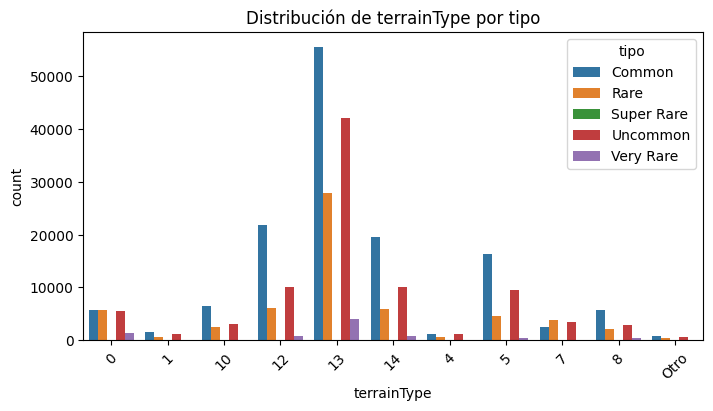

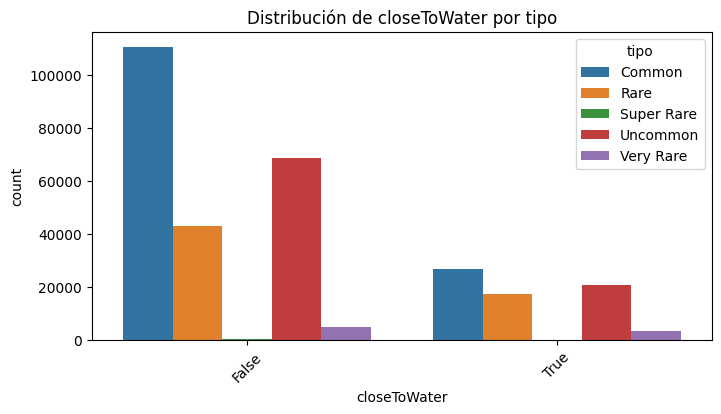

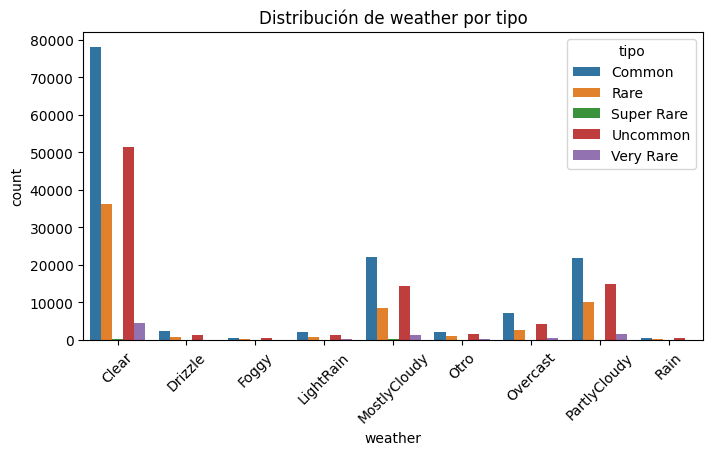

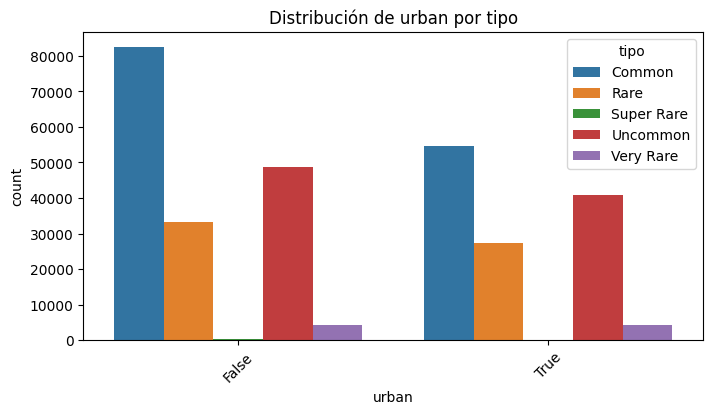

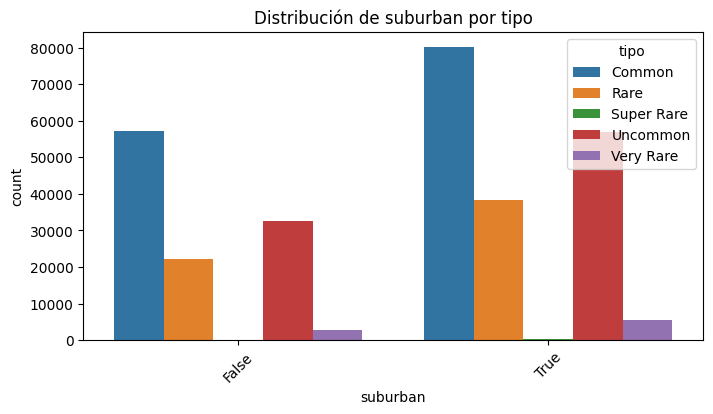

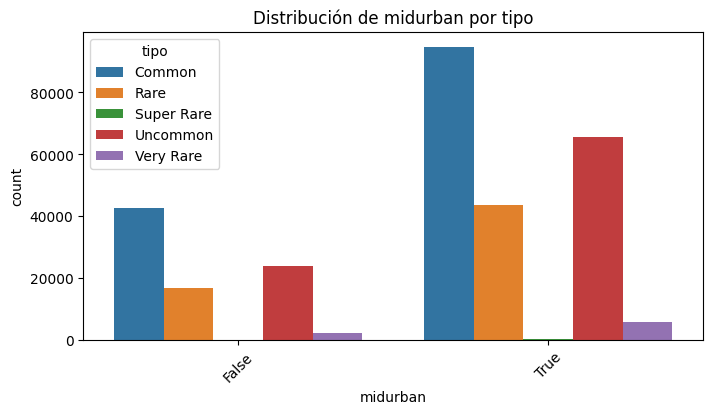

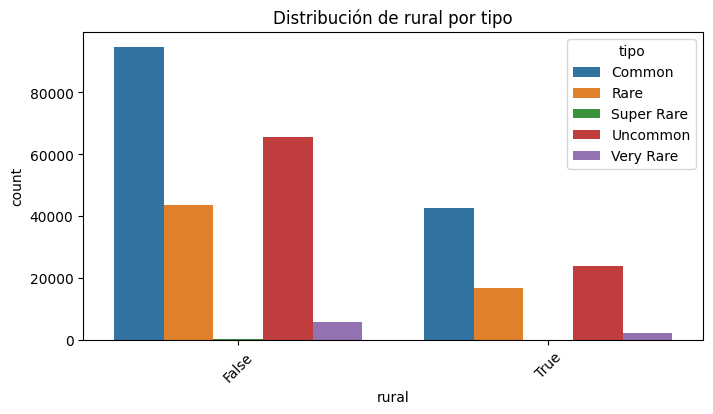

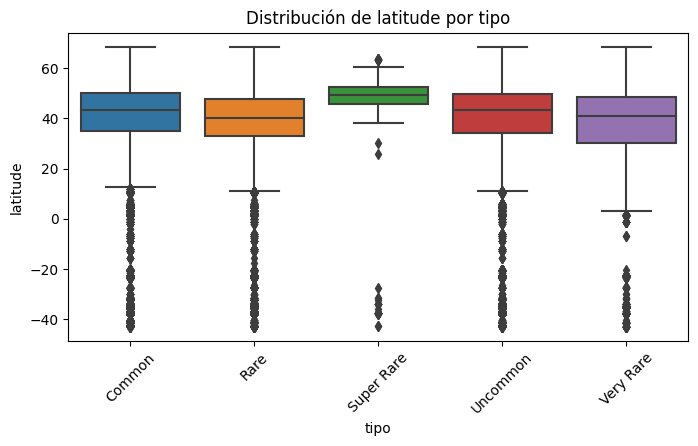

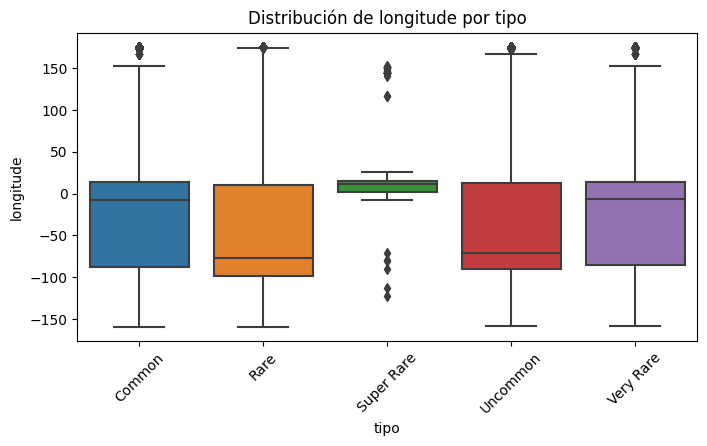

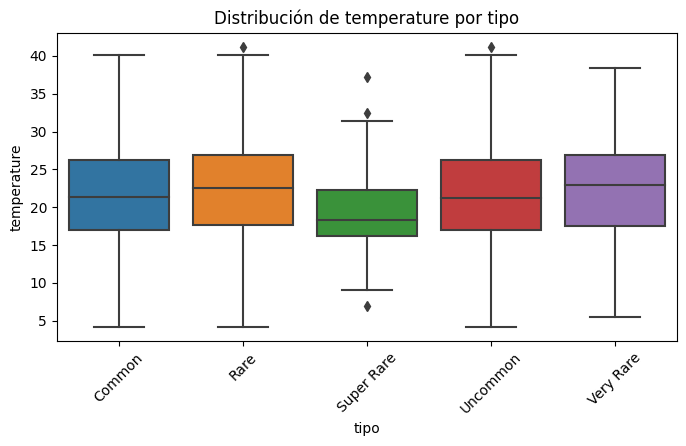

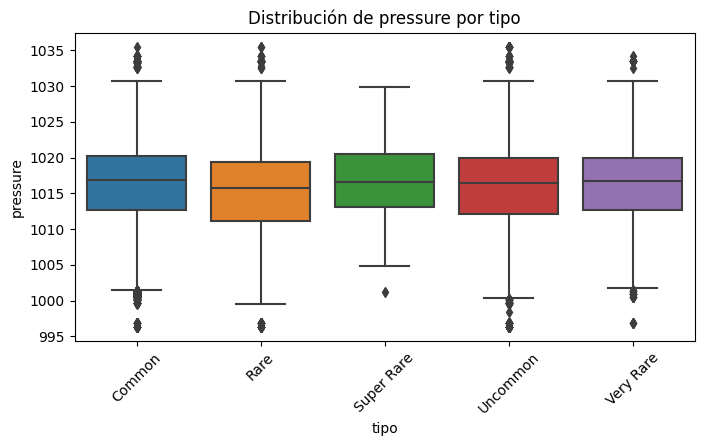

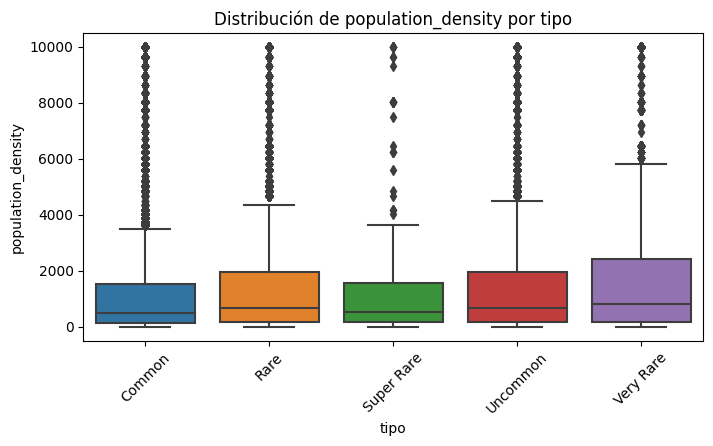

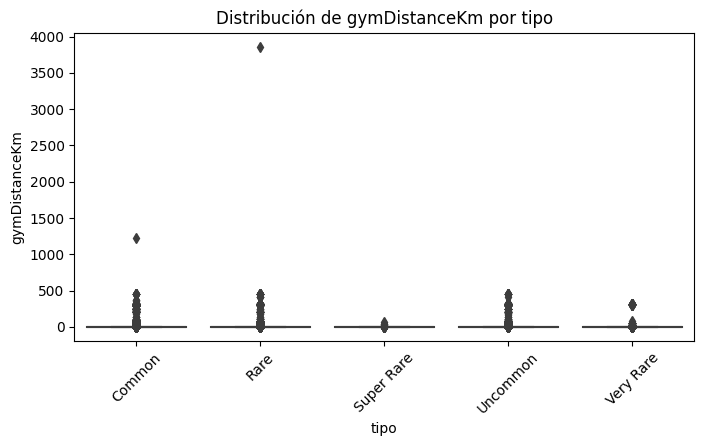

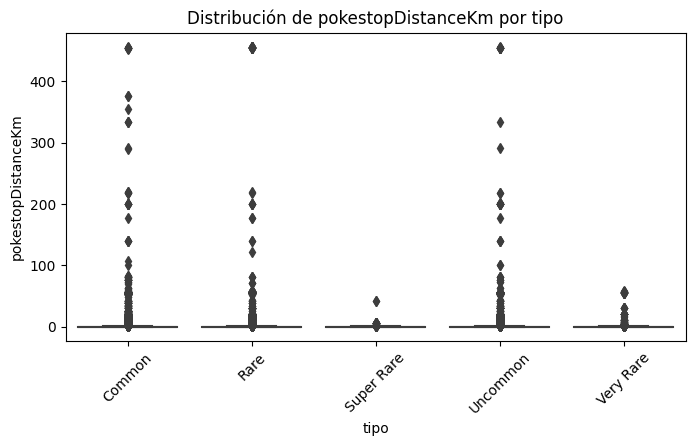

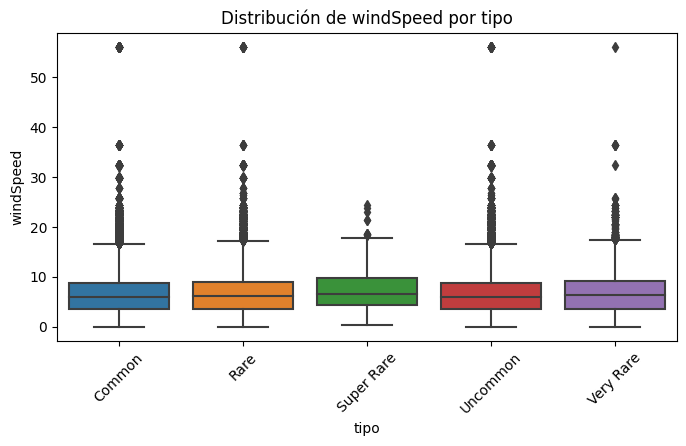

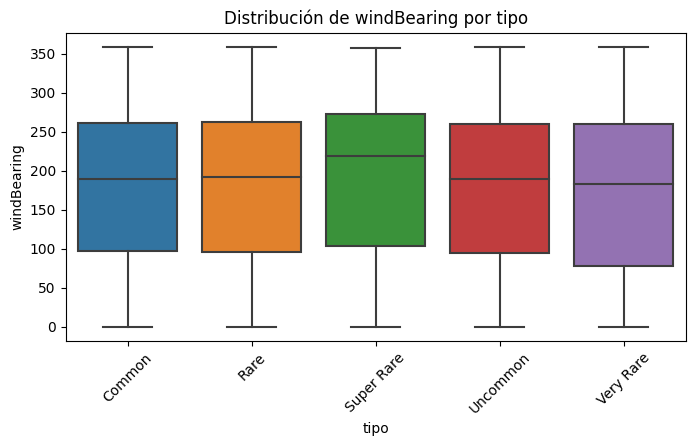

Resumen estadístico de latitude por tipo:
               count       mean        std        min        25%        50%  \
tipo                                                                          
Common      137271.0  39.246910  17.183702 -42.983899  34.897179  43.337765   
Rare         60527.0  37.075971  16.825602 -42.981578  32.945015  39.957346   
Super Rare     400.0  42.445543  24.476441 -42.833684  45.723884  49.433617   
Uncommon     89520.0  39.386418  16.608579 -42.982973  34.105235  43.112761   
Very Rare     8303.0  36.563936  18.878495 -42.984504  30.043245  40.786451   

                  75%        max  
tipo                              
Common      49.953191  68.438473  
Rare        47.662463  68.437968  
Super Rare  52.359435  63.430707  
Uncommon    49.592909  68.436760  
Very Rare   48.301400  68.235080  


Resumen estadístico de longitude por tipo:
               count       mean        std         min        25%        50%  \
tipo                              

In [146]:
# Variables categóricas
categorical_columns = ['terrainType', 'closeToWater', 'weather', 'urban', 'suburban', 'midurban', 'rural']

for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=pok, x=column, hue='tipo')
    plt.title(f'Distribución de {column} por tipo')
    plt.xticks(rotation=45)
    plt.show()

# Variables numéricas
numeric_columns = ['latitude', 'longitude', 'temperature', 'pressure', 'population_density', 'gymDistanceKm', 'pokestopDistanceKm', 'windSpeed', 'windBearing']

for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=pok, x='tipo', y=column)
    plt.title(f'Distribución de {column} por tipo')
    plt.xticks(rotation=45)
    plt.show()

# Resumen estadístico
for column in numeric_columns:
    summary = pok.groupby('tipo')[column].describe()
    print(f"Resumen estadístico de {column} por tipo:")
    print(summary)
    print("\n")

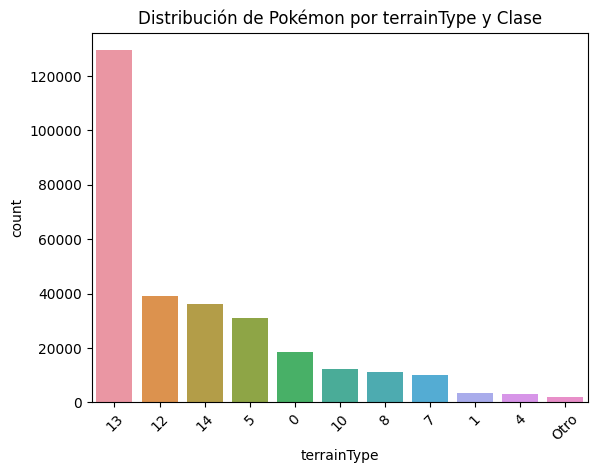

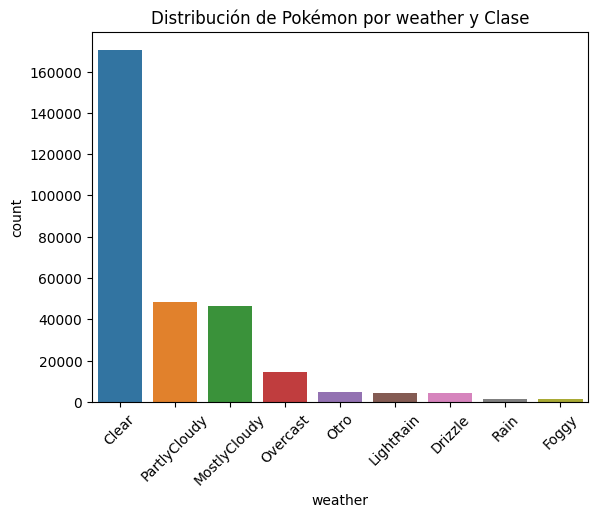

Tabla de contingencia para terrainType vs. Clase:
tipo         Common   Rare  Super Rare  Uncommon  Very Rare
terrainType                                                
0              5811   5690          12      5477       1397
1              1550    707           9      1180         79
10             6480   2432          28      3177        122
12            21856   6145          89     10176        819
13            55506  27853         148     41991       3960
...             ...    ...         ...       ...        ...
4              1237    675           0      1129         11
5             16345   4677          72      9532        532
7              2525   3931           4      3452         65
8              5658   2176           3      2840        433
Otro            836    397           4       550         54

[11 rows x 5 columns]


Tabla de contingencia para weather vs. Clase:
tipo          Common   Rare  Super Rare  Uncommon  Very Rare
weather                               

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de columnas predictoras (excluyendo 'class')
predictor_columns = ['latitude', 'longitude', 'terrainType', 'closeToWater', 'weather',
                      'temperature', 'pressure', 'population_density', 'urban', 'suburban',
                      'midurban', 'rural', 'gymDistanceKm', 'pokestopDistanceKm', 'windSpeed', 'windBearing']

# Realiza un bucle para crear gráficos de barras para cada columna
for column in predictor_columns:
    if pok[column].dtype == 'category':  # Verifica si la columna es categórica
        category_counts = pok[column].value_counts().sort_values(ascending=False)
        sns.countplot(data=pok, x=column, order=category_counts.index)
        plt.title(f'Distribución de Pokémon por {column} y Clase')
        plt.xticks(rotation=45)
        plt.show()

# Tablas de contingencia para columnas categóricas
for column in predictor_columns:
    if pok[column].dtype == 'category':
        contingency_table = pd.crosstab(poke[column], pok['tipo'])
        print(f'Tabla de contingencia para {column} vs. Clase:')
        print(contingency_table)
        print('\n')


In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()

# Aplicar LabelEncoder a las variables categóricas en el conjunto de datos 'pok'
categorical_columns = ['hour', 'minute', 'weather', 'terrainType']
for column in categorical_columns:
    pok[column] = label_encoder.fit_transform(pok[column])

# Codificar la variable respuesta 'tipo' en el conjunto de datos 'pok'
pok['tipo'] = label_encoder.fit_transform(pok['tipo'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(pok.drop(columns=['tipo']), pok['tipo'], test_size=0.2, random_state=42)


In [17]:
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
# Crear una instancia del clasificador XGBoost con los parámetros
params = {
    'tree_method': 'gpu_hist',
    'max_depth': 12,
    'alpha': 0.1,  # REGULARIZATION
    'gamma': 0.3,
    'subsample': 0.6,
    'learning_rate': 0.05,# eta
    'objective': 'multi:softmax',
    'num_class': 5,
    'eval_metric': ['merror','mlogloss']
   }

model1 = XGBClassifier(**params)
model1.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=5, num_parallel_tree=None, ...)

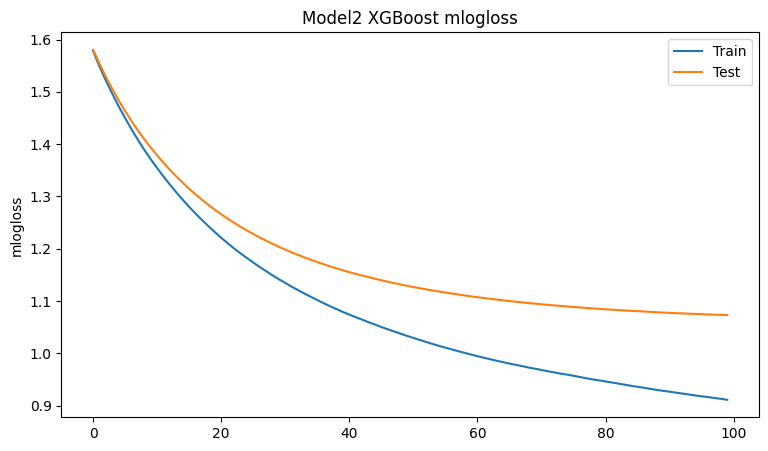

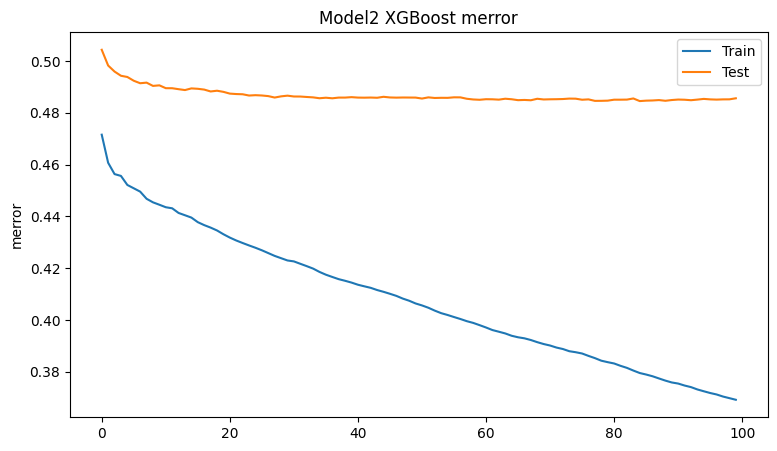

In [18]:
# preparing evaluation metric plots
results = model1.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model2 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model2 XGBoost merror')
plt.show()

In [19]:
y_pred1 = model1.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion1 = confusion_matrix(y_test, y_pred1)
print("Matriz de Confusión:\n", confusion1)
from sklearn.metrics import classification_report
report1 = classification_report(y_test, y_pred1)
print("Reporte de Clasificación:\n", report1)

Matriz de Confusión:
 [[22918  1316     0  3228     8]
 [ 6570  2956     0  2513   128]
 [   72     3     0     6     1]
 [11573  1758     0  4471    23]
 [  816   404     0   331   110]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.55      0.83      0.66     27470
           1       0.46      0.24      0.32     12167
           2       0.00      0.00      0.00        82
           3       0.42      0.25      0.32     17825
           4       0.41      0.07      0.11      1661

    accuracy                           0.51     59205
   macro avg       0.37      0.28      0.28     59205
weighted avg       0.49      0.51      0.47     59205



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


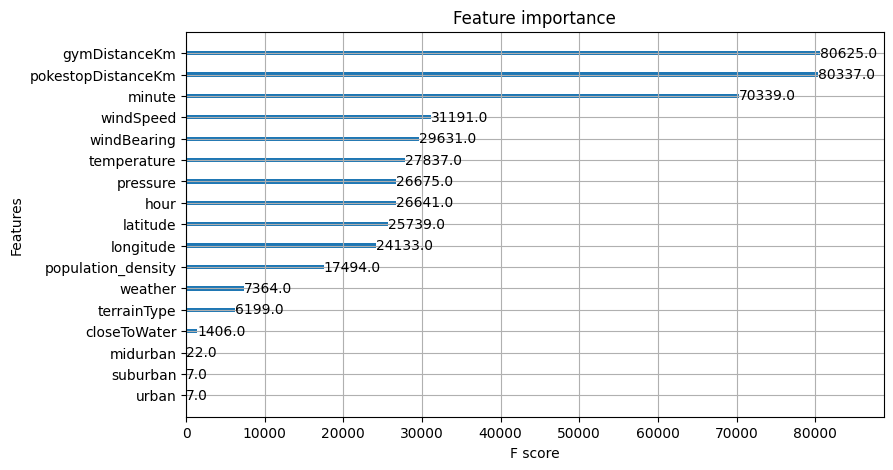

In [23]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(model1, ax=ax)
plt.show()

In [24]:
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
# Crear una instancia del clasificador XGBoost con los parámetros
params2 = {
    'tree_method': 'gpu_hist',
    'max_depth': 10,
    'alpha': 0.1,  # REGULARIZATION
    'gamma': 0.3,
    'subsample': 0.6,
    'learning_rate': 0.05,# eta
    'objective': 'multi:softprob',
    'num_class': 5,
    'eval_metric': ['merror','mlogloss']
   }

model2 = XGBClassifier(**params2)

# Ajustar el modelo a los datos de entrenamiento
model2.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=5, num_parallel_tree=None, ...)

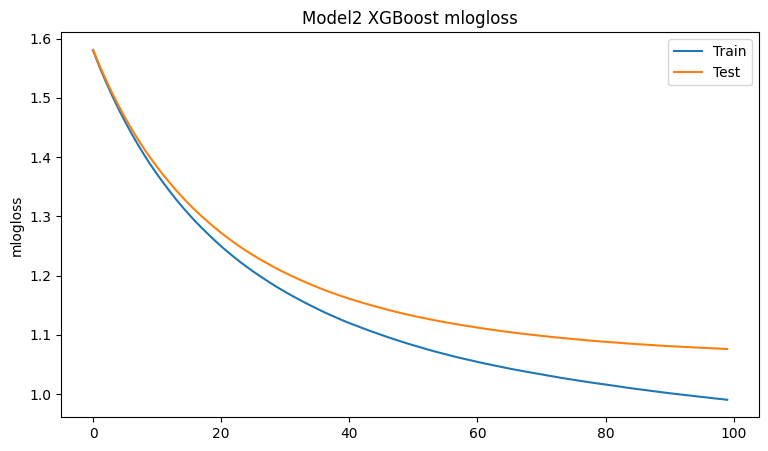

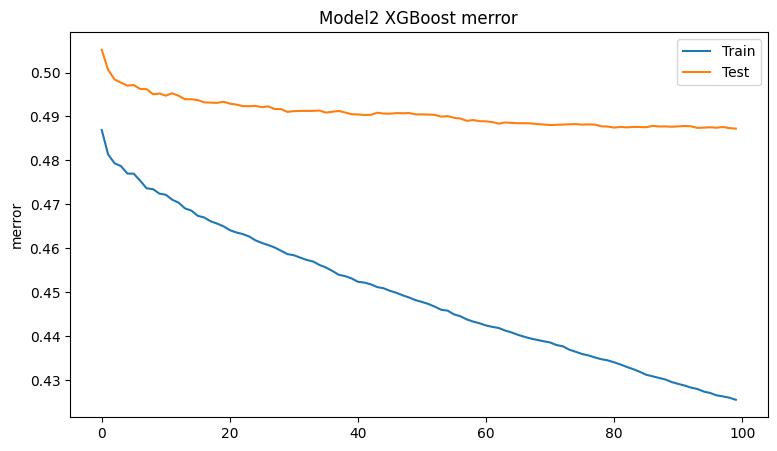

In [25]:
# preparing evaluation metric plots
results = model2.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model2 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model2 XGBoost merror')
plt.show()

In [26]:
y_pred2 = model2.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion2 = confusion_matrix(y_test, y_pred2)
print("Matriz de Confusión:\n", confusion2)
from sklearn.metrics import classification_report
report2 = classification_report(y_test, y_pred2)
print("Reporte de Clasificación:\n", report2)

Matriz de Confusión:
 [[23440  1280     0  2741     9]
 [ 6993  2859     0  2229    86]
 [   73     4     0     5     0]
 [12142  1693     0  3978    12]
 [  933   356     0   291    81]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.54      0.85      0.66     27470
           1       0.46      0.23      0.31     12167
           2       0.00      0.00      0.00        82
           3       0.43      0.22      0.29     17825
           4       0.43      0.05      0.09      1661

    accuracy                           0.51     59205
   macro avg       0.37      0.27      0.27     59205
weighted avg       0.49      0.51      0.46     59205



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


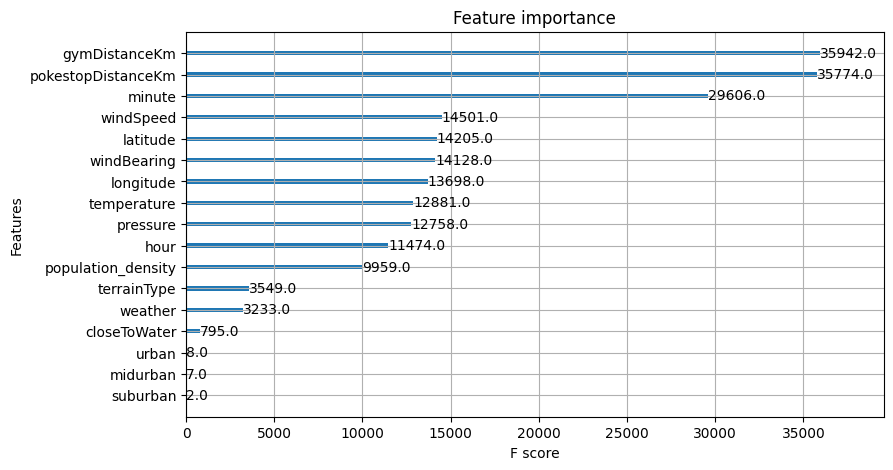

In [68]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(model2, ax=ax)
plt.show()

In [27]:
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.utils import class_weight
wb = class_weight.compute_sample_weight(class_weight='balanced',y=y_train)
# Crear una instancia del clasificador XGBoost con los parámetros
params3 = {
    'tree_method': 'gpu_hist',
    'max_depth': 10,
    'alpha': 0.1,  # REGULARIZATION
    'gamma': 0.3,
    'subsample': 0.6,
    'learning_rate': 0.05,# eta
    'objective': 'multi:softprob',
    'num_class':5,
    'eval_metric': ['merror','mlogloss']
   }

model3 = XGBClassifier(**params2)

# Ajustar el modelo a los datos de entrenamiento
model3.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0,sample_weight=wb)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=5, num_parallel_tree=None, ...)

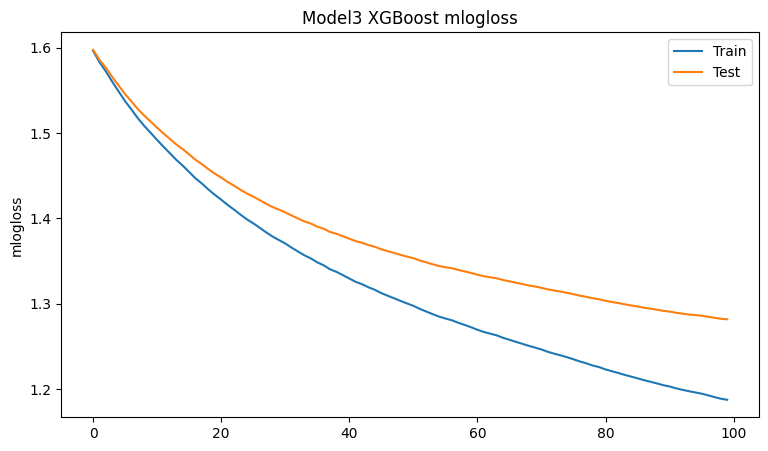

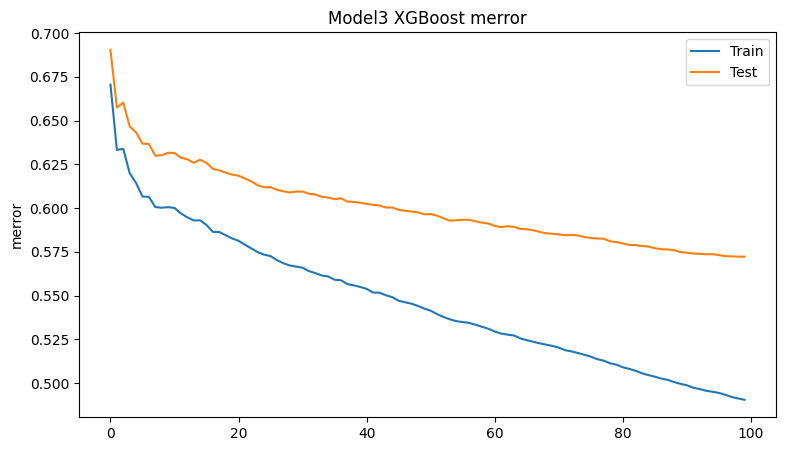

In [28]:
# preparing evaluation metric plots
results = model3.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model3 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model3 XGBoost merror')
plt.show()

In [29]:
y_pred3 = model3.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion3 = confusion_matrix(y_test, y_pred3)
print("Matriz de Confusión:\n", confusion3)
from sklearn.metrics import classification_report
report3 = classification_report(y_test, y_pred3)
print("Reporte de Clasificación:\n", report3)

Matriz de Confusión:
 [[14953  3690  1194  5280  2353]
 [ 2877  4138   370  2558  2224]
 [   46     9     9    12     6]
 [ 6113  3637   746  5290  2039]
 [  239   268    40   182   932]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.62      0.54      0.58     27470
           1       0.35      0.34      0.35     12167
           2       0.00      0.11      0.01        82
           3       0.40      0.30      0.34     17825
           4       0.12      0.56      0.20      1661

    accuracy                           0.43     59205
   macro avg       0.30      0.37      0.29     59205
weighted avg       0.48      0.43      0.45     59205



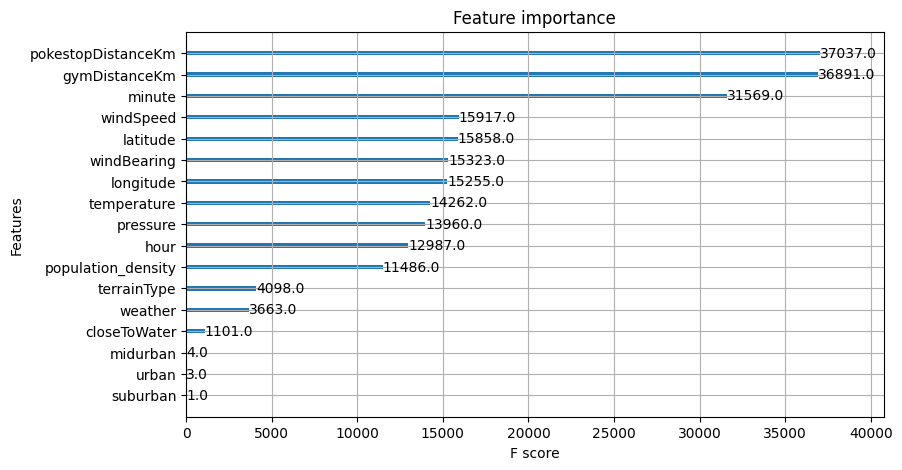

In [69]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(model3, ax=ax)
plt.show()

In [30]:
pok = pok.drop(['urban','midurban','suburban','rural'], axis=1)

In [31]:
# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()

# Aplicar LabelEncoder a las variables categóricas en el conjunto de datos 'pok'
categorical_columns = ['hour', 'minute', 'weather', 'terrainType']
for column in categorical_columns:
    pok[column] = label_encoder.fit_transform(pok[column])

# Codificar la variable respuesta 'tipo' en el conjunto de datos 'pok'
pok['tipo'] = label_encoder.fit_transform(pok['tipo'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_trainx, X_testx, y_trainx, y_testx = train_test_split(pok.drop(columns=['tipo']), pok['tipo'], test_size=0.2, random_state=42)


In [77]:
pok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296021 entries, 0 to 296020
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   latitude            296021 non-null  float64
 1   longitude           296021 non-null  float64
 2   terrainType         296021 non-null  int64  
 3   closeToWater        296021 non-null  bool   
 4   weather             296021 non-null  int64  
 5   temperature         296021 non-null  float64
 6   windSpeed           296021 non-null  float64
 7   windBearing         296021 non-null  int64  
 8   pressure            296021 non-null  float64
 9   population_density  296021 non-null  float64
 10  gymDistanceKm       296021 non-null  float64
 11  pokestopDistanceKm  296021 non-null  float64
 12  tipo                296021 non-null  int64  
 13  hour                296021 non-null  int64  
 14  minute              296021 non-null  int64  
dtypes: bool(1), float64(8), int64(6)
m

In [32]:
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.utils import class_weight
#we = class_weight.compute_sample_weight(class_weight=None,y=y_train)
# Crear una instancia del clasificador XGBoost con los parámetros
params4 = {
    'tree_method': 'gpu_hist',
    'max_depth': 10,
    'alpha': 0.1,  # REGULARIZATION
    'gamma': 0.3,
    'subsample': 0.6,
    'learning_rate': 0.05,# eta
    'objective': 'multi:softprob',
    'num_class': 5,
    'eval_metric': ['merror','mlogloss']
   }

model4 = XGBClassifier(**params2)

# Ajustar el modelo a los datos de entrenamiento
model4.fit(X_trainx, y_trainx,eval_set=[(X_trainx, y_trainx), (X_testx, y_testx)], verbose=0)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=5, num_parallel_tree=None, ...)

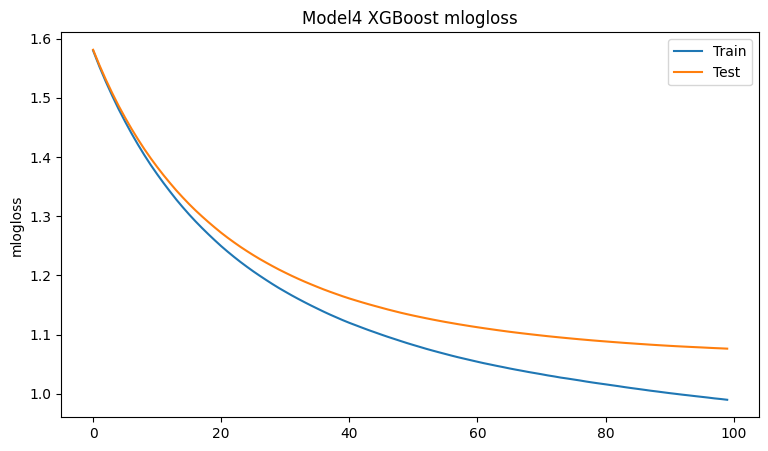

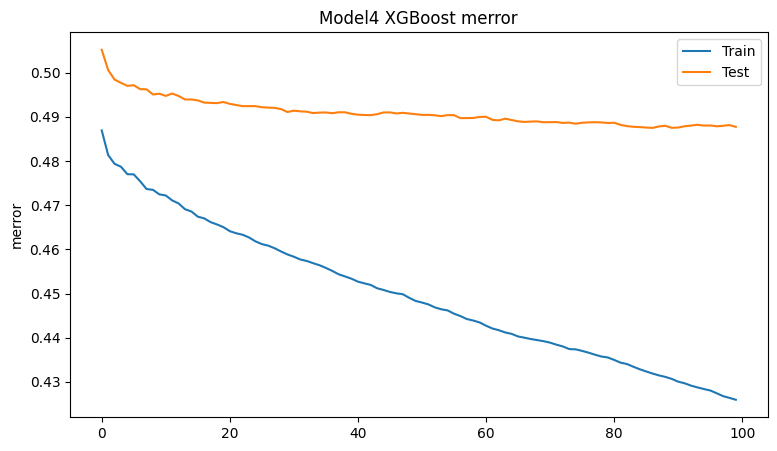

In [33]:
# preparing evaluation metric plots
results = model4.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model4 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model4 XGBoost merror')
plt.show()

In [34]:
y_pred4 = model4.predict(X_testx)
from sklearn.metrics import confusion_matrix
confusion4 = confusion_matrix(y_testx, y_pred4)
print("Matriz de Confusión:\n", confusion4)
from sklearn.metrics import classification_report
report4 = classification_report(y_testx, y_pred4)
print("Reporte de Clasificación:\n", report4)

Matriz de Confusión:
 [[23445  1284     0  2733     8]
 [ 6992  2860     0  2232    83]
 [   72     4     0     6     0]
 [12152  1713     0  3947    13]
 [  930   360     0   294    77]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.54      0.85      0.66     27470
           1       0.46      0.24      0.31     12167
           2       0.00      0.00      0.00        82
           3       0.43      0.22      0.29     17825
           4       0.43      0.05      0.08      1661

    accuracy                           0.51     59205
   macro avg       0.37      0.27      0.27     59205
weighted avg       0.48      0.51      0.46     59205



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


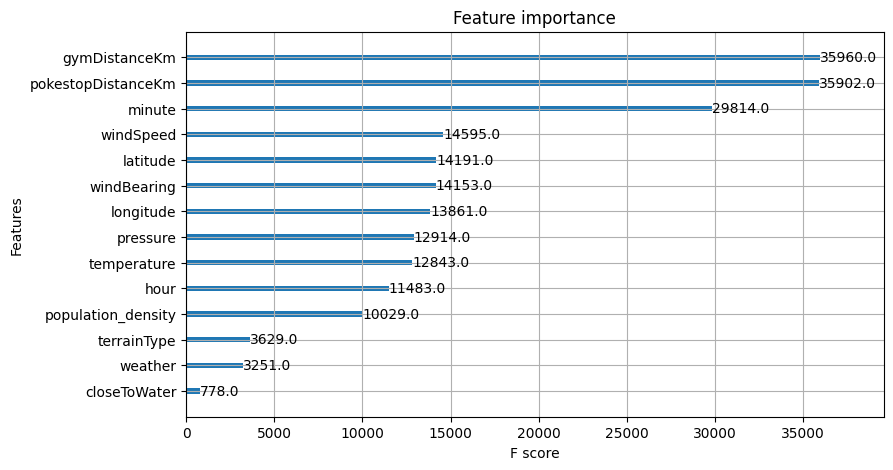

In [84]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(model4, ax=ax)
plt.show()

In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate

'''params4 = {
        #'tree_method': 'gpu_hist',
        #'num_class':144,
        'subsample': [0.5,0.75, 1],
        'colsample_bynode': [0.5, 0.75, 1],
        'learning_rate': [0.05, 0.1, 0.3],
        'max_depth':[ 3, 5, 7, 10],
        'min_child_weight':[1, 1.5, 2],
        'gamma': [ 0.1, 0.2, 0.5],
        'n_estimators': [100, 150, 200]
        }'''
params5 = {
        #'tree_method': 'gpu_hist',
        #'num_class':144,
        'subsample': [0.5, 1],
        'colsample_bynode': [0.5, 1],
        'learning_rate': [0.05, 0.3],
        'max_depth':[ 3, 6, 10],
        'min_child_weight':[1, 2],
        'gamma': [ 0.1, 0.5],
        'n_estimators': [100, 200]
        }


clf = xgb.XGBClassifier(objective='multi:softprob', tree_method='gpu_hist', random_state=123)
stratified_kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=123)
grid_search = GridSearchCV(clf, params5, scoring="neg_log_loss", n_jobs=-1, cv=stratified_kfold, verbose=2)

In [16]:
grid_result = grid_search.fit(X_train, y_train, verbose=0)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  10.8s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   9.8s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   9.0s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   7.6s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   4.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; total time=   7.0s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  10.9s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   9.8s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   9.4s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.8s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.4s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  13.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  10.9s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   9.8s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   9.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.4s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  14.2s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  10.8s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   9.8s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   9.4s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   7.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; total time=   9.4s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  14.3s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=   8.6s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=  17.2s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  33.2s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  33.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  33.6s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  33.3s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  14.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  27.1s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  33.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  18.3s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  16.4s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  33.4s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  15.8s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  17.4s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=   9.6s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=  12.6s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  33.8s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 3.2min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 3.1min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time= 3.4min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time= 3.4min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time= 1.5min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time= 1.5min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, su

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time= 1.5min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time= 1.5min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time= 1.2min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time= 1.3min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 3.1min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 3.1min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.5; total time= 2.8min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time= 1.3min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time= 1.3min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.9s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.4s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   7.7s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  16.7s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  16.6s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=   9.7s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=  10.5s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  31.9s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  31.5s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; t

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  11.5s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time= 1.3min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time= 1.3min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time= 1.3min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  31.0s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 2.5min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time= 1.3min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time= 1.2min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time= 1.2min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=100, subsample=1; total time=  27.6s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.5; total time= 2.4min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.5; total time= 2.4min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsamp

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  12.4s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  13.8s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  20.1s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  21.7s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  12.6s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=   8.6s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total ti

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  19.8s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  20.2s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  19.1s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  25.4s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  21.8s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  20.7s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  54.2s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  54.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  54.2s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  52.6s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  27.4s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  27.6s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, subsample=1; total

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  21.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  54.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  53.4s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  46.5s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  20.9s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  21.8s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  21.8s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  21.4s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  19.6s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  53.4s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  53.8s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  30.4s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  51.4s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  41.5s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  25.1s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  25.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  26.9s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  26.3s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=100, subsample=1; total time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  47.4s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time=  27.4s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time=  24.2s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   6.8s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   7.8s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   7.9s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time= 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  49.2s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  48.2s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  46.9s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time=  38.0s


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  27.4s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  27.3s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  51.1s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  49.2s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  49.0s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  41.5s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total

In [17]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -1.059259 using {'colsample_bynode': 0.5, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1}
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  10.3s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  43.7s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  49.3s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  18.7s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  16.5s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsampl

In [37]:
best_params = {
    'colsample_bynode': 0.5,
    'gamma': 0.5,
    'learning_rate': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 1,
    'num_class':5,
    'eval_metric': ['merror','mlogloss']
}

best_model = XGBClassifier(tree_method='gpu_hist', **best_params)
best_model.fit(X_train, y_train, sample_weight=wb,eval_set=[(X_train, y_train), (X_test, y_test)],verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.5,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_class=5, num_parallel_tree=None, objective='multi:softprob', ...)

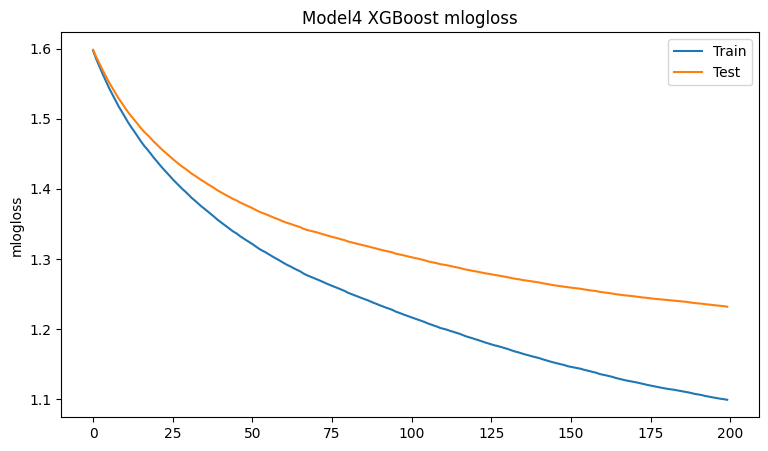

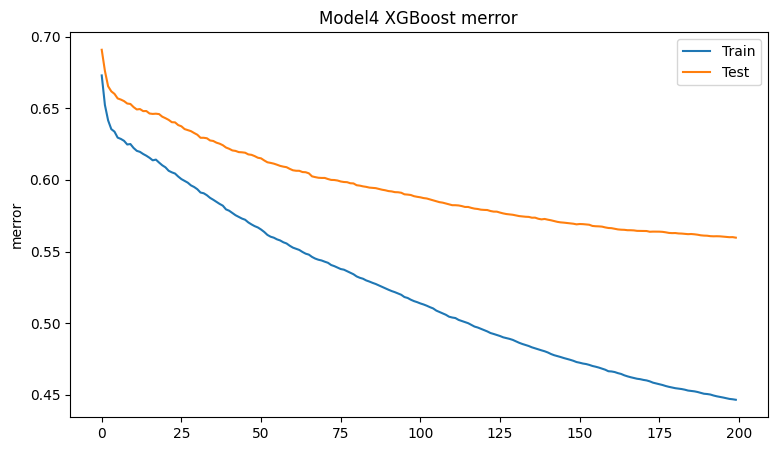

In [38]:
# preparing evaluation metric plots
results = best_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model4 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model4 XGBoost merror')
plt.show()

In [39]:
y_pred5 = best_model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred5))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))

Matriz de Confusión:
 [[15233  3860   737  5616  2024]
 [ 2859  4322   227  2732  2027]
 [   43    11     7    14     7]
 [ 6157  3866   486  5594  1722]
 [  230   300    22   196   913]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.62      0.55      0.59     27470
           1       0.35      0.36      0.35     12167
           2       0.00      0.09      0.01        82
           3       0.40      0.31      0.35     17825
           4       0.14      0.55      0.22      1661

    accuracy                           0.44     59205
   macro avg       0.30      0.37      0.30     59205
weighted avg       0.48      0.44      0.46     59205



In [40]:
best_params = {
    'colsample_bynode': 0.5,
    'gamma': 0.5,
    'learning_rate': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 1,
    'num_class':5,
    'eval_metric': ['merror','mlogloss']
    
}

best_model2 = XGBClassifier(tree_method='gpu_hist', **best_params)
best_model2.fit(X_trainx, y_trainx, sample_weight=wb,eval_set=[(X_trainx, y_trainx), (X_testx, y_testx)],verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.5,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_class=5, num_parallel_tree=None, objective='multi:softprob', ...)

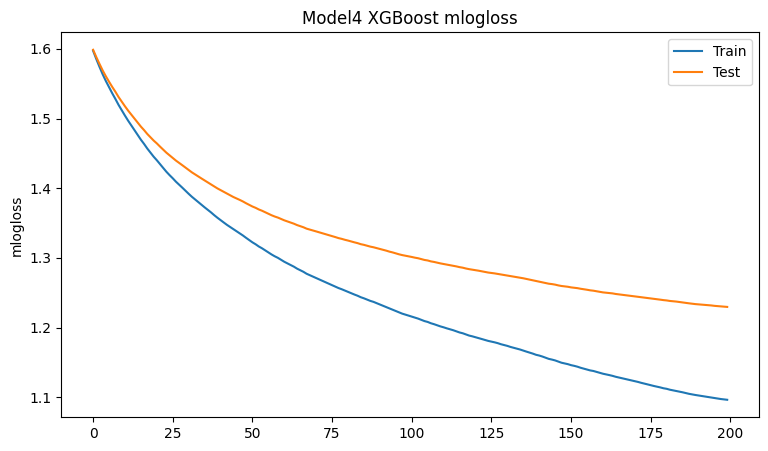

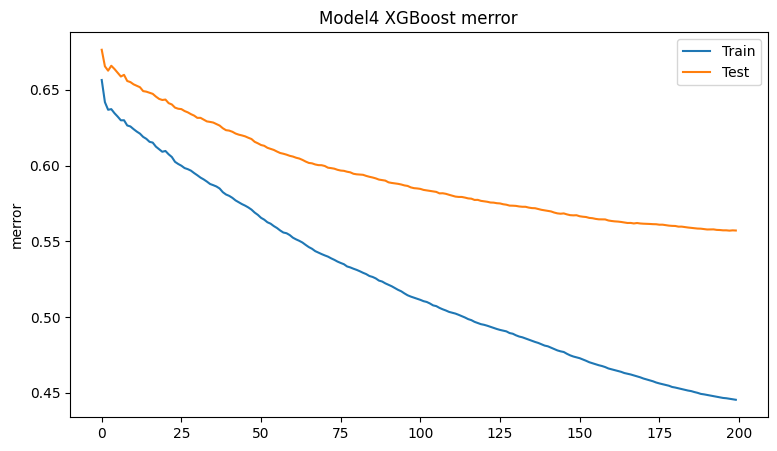

In [44]:
# preparing evaluation metric plots
results = best_model2.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model4 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model4 XGBoost merror')
plt.show()

In [41]:
y_predx = best_model2.predict(X_testx)
from sklearn.metrics import classification_report, confusion_matrix
print("Matriz de Confusión:\n", confusion_matrix(y_testx, y_predx))
print("Reporte de Clasificación:\n", classification_report(y_testx, y_predx))

Matriz de Confusión:
 [[15383  3845   643  5606  1993]
 [ 2884  4288   195  2745  2055]
 [   47     8     7    12     8]
 [ 6221  3804   423  5615  1762]
 [  217   294    19   207   924]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59     27470
           1       0.35      0.35      0.35     12167
           2       0.01      0.09      0.01        82
           3       0.40      0.32      0.35     17825
           4       0.14      0.56      0.22      1661

    accuracy                           0.44     59205
   macro avg       0.30      0.37      0.30     59205
weighted avg       0.48      0.44      0.46     59205



In [43]:
best_params = {
    'colsample_bynode': 0.5,
    'gamma': 0.5,
    'learning_rate': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 1,
    'num_class':5,
    'eval_metric': ['merror','mlogloss']
}

best_model3 = XGBClassifier(tree_method='gpu_hist', **best_params)
best_model3.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.5,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_class=5, num_parallel_tree=None, objective='multi:softprob', ...)

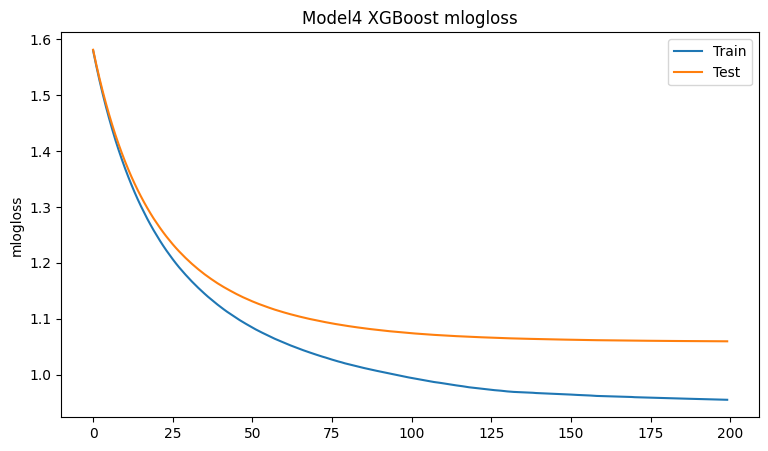

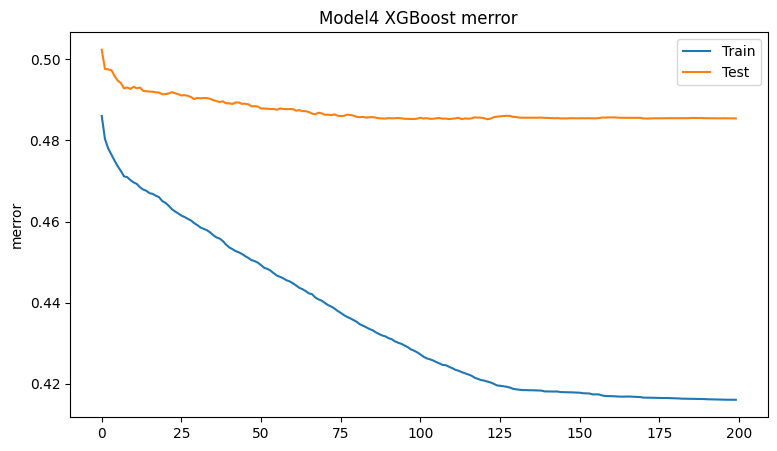

In [45]:
# preparing evaluation metric plots
results = best_model3.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model4 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model4 XGBoost merror')
plt.show()

In [47]:
y_pred3 = best_model3.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred3))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred3))

Matriz de Confusión:
 [[23205  1317     0  2933    15]
 [ 6817  2902     0  2328   120]
 [   70     4     0     8     0]
 [11811  1746     0  4246    22]
 [  876   372     0   299   114]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.54      0.84      0.66     27470
           1       0.46      0.24      0.31     12167
           2       0.00      0.00      0.00        82
           3       0.43      0.24      0.31     17825
           4       0.42      0.07      0.12      1661

    accuracy                           0.51     59205
   macro avg       0.37      0.28      0.28     59205
weighted avg       0.49      0.51      0.47     59205



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.model_selection import KFold

params6 = {
    'subsample': [0.5, 1],
    'colsample_bynode': [0.5, 1],
    'learning_rate': [0.05, 0.3],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 2],
    'gamma': [0.1, 0.5],
    'n_estimators': [100, 200]
}

clf = xgb.XGBClassifier(objective='multi:softprob', tree_method='gpu_hist', random_state=123)
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
grid_search = GridSearchCV(clf, params6, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=2)

In [20]:
grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  11.2s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   9.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   8.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   7.6s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   4.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  11.6s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  10.9s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   9.6s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.4s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   7.3s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  12.3s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  11.1s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   9.6s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.4s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   8.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  12.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  10.9s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   9.2s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   7.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   4.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   6.2s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  12.0s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  35.2s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  33.9s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  34.3s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  30.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  15.0s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  16.2s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  24.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  28.3s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  18.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  15.3s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  16.9s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=  15.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  15.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=  12.8s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=  16.1s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=  16.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  33.8s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  33.6s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 3.2min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 3.0min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 3.1min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time= 3.3min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time= 3.3min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time= 1.5min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, su

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  33.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  33.5s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  31.7s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  31.2s
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time= 1.5min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time= 1.5min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 3.2min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time= 3.3min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time= 3.4min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time= 3.4min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time= 1.5min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.5; total time= 1.6min
[CV] END colsample_bynode=0.5, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=100, subs

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  30.9s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 2.5min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 2.5min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  32.4s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  33.4s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; total time=  33.1s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=1; 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time=  33.6s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time=  26.9s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   7.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   7.6s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   4.3s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   5.3s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  13.9s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  14.1s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time= 1.3min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time= 1.3min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time= 1.2min
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  29.9s
[CV] END colsample_bynode=0.5, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  18.1s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=1; total time=  17.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=  10.1s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.5; total time=   5.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=   9.5s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=  11.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=  1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  30.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  29.5s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  30.1s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  29.5s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  53.3s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  51.4s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.5; t

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  13.5s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  19.8s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  29.3s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  30.1s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  30.3s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total time=  30.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1; total tim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=100, subsample=1; total time=   4.9s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  19.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  21.2s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  20.0s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  20.8s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=200, subsample=1; total time=  22.9s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  29.1s

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  50.3s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  51.5s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time=  29.7s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time=  25.7s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time=  25.5s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   9.4s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.5; total time=  48.8s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time=  24.5s
[CV] END colsample_bynode=1, gamma=0.1, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1; total time=  20.1s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   6.7s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   6.0s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time=   4.5s
[CV] END colsample_bynode=1, gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1; total time= 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best: -1.059100 using {'colsample_bynode': 0.5, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1}


In [48]:
best_params2 = {
    'colsample_bynode': 0.5,
    'gamma': 0.5,
    'learning_rate': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 1,
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'max_delta_step': 0,
    'eval_metric': ['merror','mlogloss'],
    'seed': 123,
    'max_leaves': 0,
    'max_bin': 256,
    'alpha': 0,
    'lambda': 1,
    'num_class':5
}

best_model4 = XGBClassifier(tree_method='gpu_hist', **best_params2)
best_model4.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose=0 )

XGBClassifier(alpha=0, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.5,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.05, max_bin=256, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=10,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_class=5, ...)

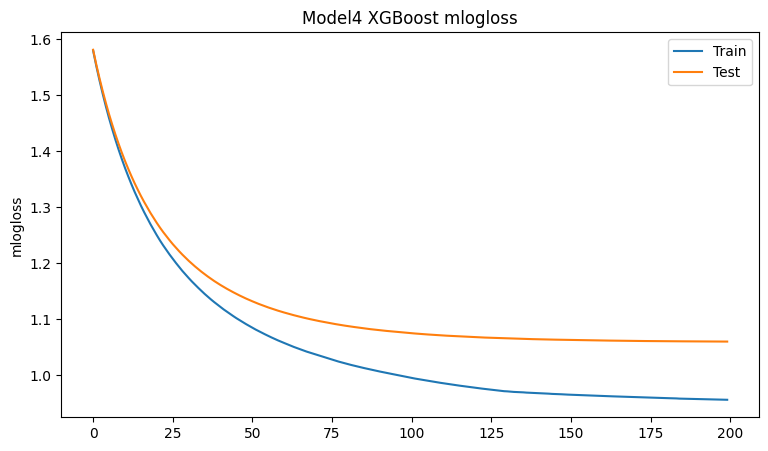

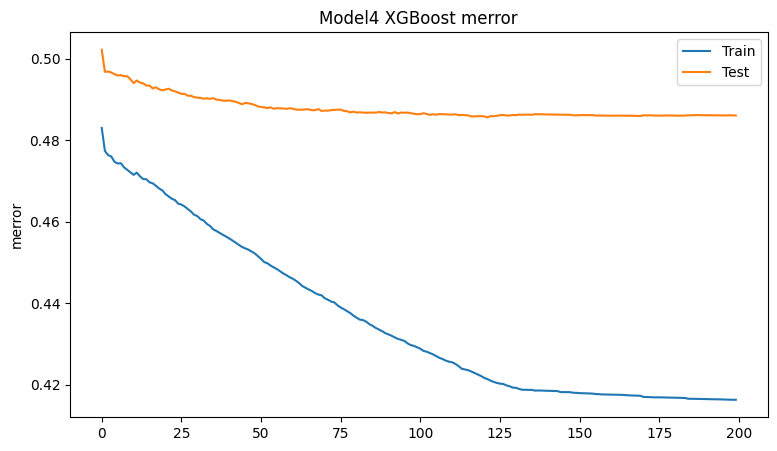

In [49]:
# preparing evaluation metric plots
results = best_model4.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model4 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model4 XGBoost merror')
plt.show()

In [50]:
y_predx2 = best_model4.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_predx2))
print("Reporte de Clasificación:\n", classification_report(y_test, y_predx2))

Matriz de Confusión:
 [[23301  1284     0  2871    14]
 [ 6880  2854     0  2310   123]
 [   71     4     0     7     0]
 [11898  1744     0  4162    21]
 [  879   368     0   306   108]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.54      0.85      0.66     27470
           1       0.46      0.23      0.31     12167
           2       0.00      0.00      0.00        82
           3       0.43      0.23      0.30     17825
           4       0.41      0.07      0.11      1661

    accuracy                           0.51     59205
   macro avg       0.37      0.28      0.28     59205
weighted avg       0.49      0.51      0.46     59205



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
best_paramsx2 = {
    'colsample_bynode': 0.5,
    'gamma': 0.5,
    'learning_rate': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 1,
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'max_delta_step': 0,
    'eval_metric': ['merror','mlogloss'],
    'seed': 123,
    'silent': 1,
    'max_leaves': 0,
    'max_bin': 256,
    'alpha': 0,
    'lambda': 1,
    'num_class':5    
}

best_modelx4 = XGBClassifier(tree_method='gpu_hist', **best_params2)
best_modelx4.fit(X_trainx, y_trainx, eval_set=[(X_trainx, y_trainx), (X_testx, y_testx)],verbose=0 )

XGBClassifier(alpha=0, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.5,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.05, max_bin=256, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=10,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_class=5, ...)

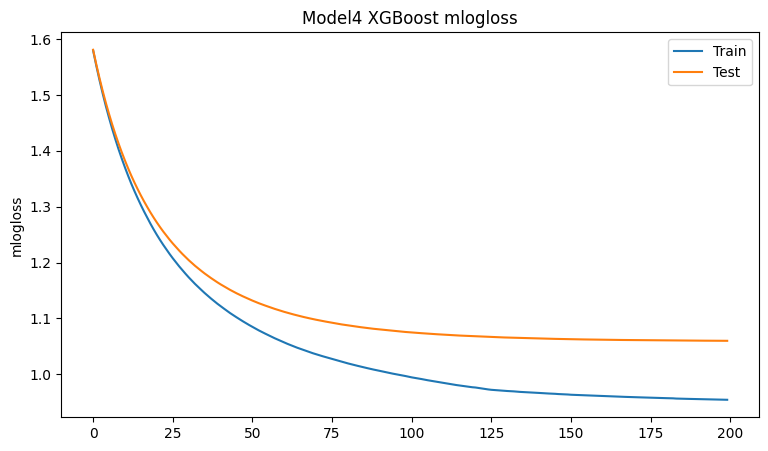

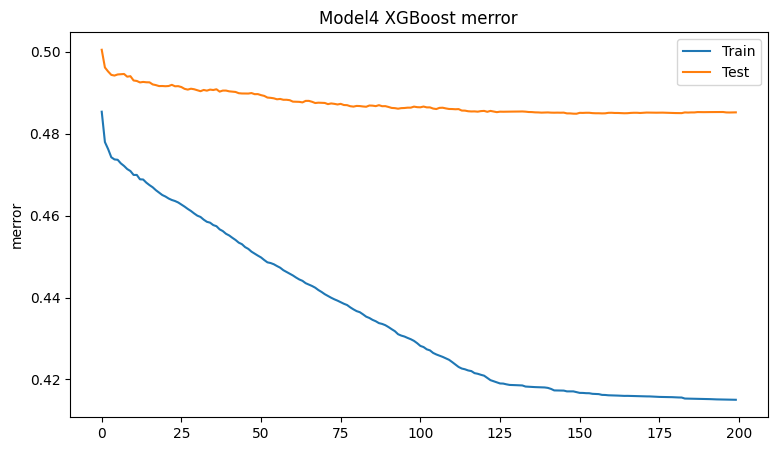

In [53]:
# preparing evaluation metric plots
results = best_modelx4.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model4 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model4 XGBoost merror')
plt.show()

In [54]:
y_predx4 = best_modelx4.predict(X_testx)
from sklearn.metrics import classification_report, confusion_matrix
print("Matriz de Confusión:\n", confusion_matrix(y_testx, y_predx4))
print("Reporte de Clasificación:\n", classification_report(y_testx, y_predx4))

Matriz de Confusión:
 [[23230  1281     0  2943    16]
 [ 6796  2883     0  2373   115]
 [   70     4     0     8     0]
 [11818  1734     0  4254    19]
 [  874   362     0   315   110]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.54      0.85      0.66     27470
           1       0.46      0.24      0.31     12167
           2       0.00      0.00      0.00        82
           3       0.43      0.24      0.31     17825
           4       0.42      0.07      0.11      1661

    accuracy                           0.51     59205
   macro avg       0.37      0.28      0.28     59205
weighted avg       0.49      0.51      0.47     59205



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
best_paramsxw2 = {
    'colsample_bynode': 0.5,
    'gamma': 0.5,
    'learning_rate': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 1,
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'max_delta_step': 0,
    'eval_metric': ['merror','mlogloss'],
    'seed': 123,
    'silent': 1,
    'max_leaves': 0,
    'max_bin': 256,
    'alpha': 0,
    'lambda': 1,
    'num_class':5 
    
}

best_modelxw4 = XGBClassifier(tree_method='gpu_hist', **best_paramsxw2)
best_modelxw4.fit(X_trainx, y_trainx,sample_weight=wb,eval_set=[(X_trainx, y_trainx), (X_testx, y_testx)],verbose=0)

[01:13:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(alpha=0, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.5,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.05, max_bin=256, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=10,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_class=5, ...)

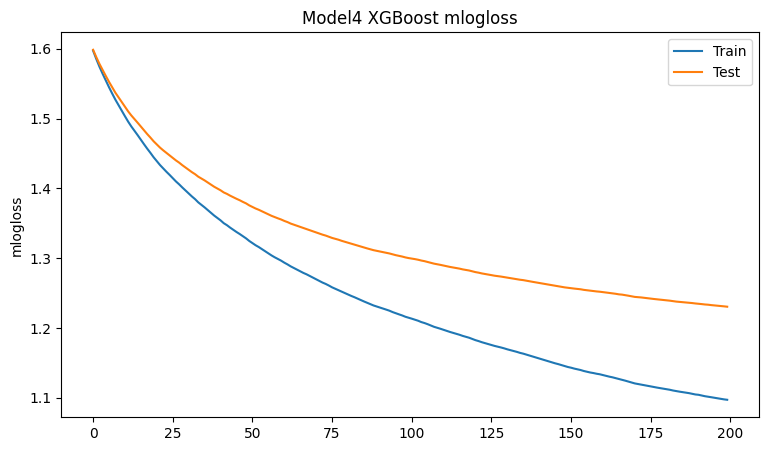

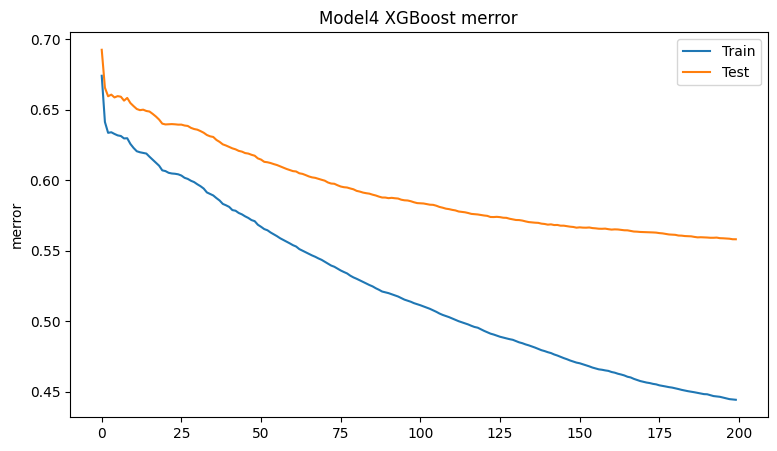

In [58]:
# preparing evaluation metric plots
results = best_modelxw4.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model4 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model4 XGBoost merror')
plt.show()

In [59]:
y_predxw4 = best_modelxw4.predict(X_testx)
from sklearn.metrics import classification_report, confusion_matrix
print("Matriz de Confusión:\n", confusion_matrix(y_testx, y_predxw4))
print("Reporte de Clasificación:\n", classification_report(y_testx, y_predx4))

Matriz de Confusión:
 [[15368  3835   687  5555  2025]
 [ 2891  4256   206  2748  2066]
 [   46     9     9    12     6]
 [ 6152  3833   458  5619  1763]
 [  225   309    19   193   915]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.54      0.85      0.66     27470
           1       0.46      0.24      0.31     12167
           2       0.00      0.00      0.00        82
           3       0.43      0.24      0.31     17825
           4       0.42      0.07      0.11      1661

    accuracy                           0.51     59205
   macro avg       0.37      0.28      0.28     59205
weighted avg       0.49      0.51      0.47     59205



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
params7 = {
    'subsample': [1.0],
    'num_class':[5],
    'colsample_bynode': [0.5],
    'learning_rate': [0.05],
    'max_depth': [10],
    'min_child_weight': [1],
    'gamma': [0.5],
    'n_estimators': [200, 250],
    'booster': ['gbtree'],
    'max_delta_step': [1, 2],
    'eval_metric': ['merror', 'logloss', 'mlogloss'],
    'max_leaves': [10, 20],
    'max_bin': [256,1024],
    'alpha': [0.5, 1],
    'lambda': [1, 10]
}

In [6]:
clf = xgb.XGBClassifier(objective='multi:softprob', tree_method='gpu_hist', random_state=123)
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
grid_search = GridSearchCV(clf, params7, scoring="neg_log_loss", n_jobs=-1, cv=stratified_kfold, verbose=2)
grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_,grid_search.best_estimator_))



Fitting 10 folds for each of 192 candidates, totalling 1920 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  20.8s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  19.4s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  16.9s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimat

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  21.3s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  19.5s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  18.9s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimat

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  20.8s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  20.0s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=250, num_class=5, subsample=1.0; total time=  21.4s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimat

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=1024, max_delta_step=1, max_depth=10, max_leaves=20, min_child_weight=1, n_estimators=250, num_class=5, subsample=1.0; total time=  29.6s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=1024, max_delta_step=2, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  16.3s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=1024, max_delta_step=2, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  17.6s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=merror, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=1024, max_delta_step=2, max_depth=10, max_leaves=10, min_child_weight=1, n_est

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=1024, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  19.2s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=1024, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  12.7s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=1024, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=250, num_class=5, subsample=1.0; total time=  18.4s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=1024, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=256, max_delta_step=2, max_depth=10, max_leaves=20, min_child_weight=1, n_estimators=250, num_class=5, subsample=1.0; total time=  29.4s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=1024, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  19.9s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=1024, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  20.2s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=1, learning_rate=0.05, max_bin=1024, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=256, max_delta_step=2, max_depth=10, max_leaves=20, min_child_weight=1, n_estimators=250, num_class=5, subsample=1.0; total time=  28.7s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=256, max_delta_step=2, max_depth=10, max_leaves=20, min_child_weight=1, n_estimators=250, num_class=5, subsample=1.0; total time=  28.9s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=1024, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  18.4s
[CV] END alpha=0.5, booster=gbtree, colsample_bynode=0.5, eval_metric=mlogloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=1024, max_delta_step=1, max_depth=10, max_leaves=10, min_child_weigh

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END alpha=1, booster=gbtree, colsample_bynode=0.5, eval_metric=logloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=20, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  16.3s
[CV] END alpha=1, booster=gbtree, colsample_bynode=0.5, eval_metric=logloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=20, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  23.3s
[CV] END alpha=1, booster=gbtree, colsample_bynode=0.5, eval_metric=logloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=20, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  23.2s
[CV] END alpha=1, booster=gbtree, colsample_bynode=0.5, eval_metric=logloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=256, max_delta_step=1, max_depth=10, max_leaves=20, min_child_weight=1, n_estimat

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END alpha=1, booster=gbtree, colsample_bynode=0.5, eval_metric=logloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=1024, max_delta_step=2, max_depth=10, max_leaves=10, min_child_weight=1, n_estimators=250, num_class=5, subsample=1.0; total time=  16.7s
[CV] END alpha=1, booster=gbtree, colsample_bynode=0.5, eval_metric=logloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=1024, max_delta_step=2, max_depth=10, max_leaves=20, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  24.2s
[CV] END alpha=1, booster=gbtree, colsample_bynode=0.5, eval_metric=logloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=1024, max_delta_step=2, max_depth=10, max_leaves=20, min_child_weight=1, n_estimators=200, num_class=5, subsample=1.0; total time=  26.1s
[CV] END alpha=1, booster=gbtree, colsample_bynode=0.5, eval_metric=logloss, gamma=0.5, lambda=10, learning_rate=0.05, max_bin=1024, max_delta_step=2, max_depth=10, max_leaves=20, min_child_weight=1, n_est

TypeError: not all arguments converted during string formatting

In [9]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Best: -1.085135 using {'alpha': 1, 'booster': 'gbtree', 'colsample_bynode': 0.5, 'eval_metric': 'merror', 'gamma': 0.5, 'lambda': 1, 'learning_rate': 0.05, 'max_bin': 1024, 'max_delta_step': 2, 'max_depth': 10, 'max_leaves': 20, 'min_child_weight': 1, 'n_estimators': 250, 'num_class': 5, 'subsample': 1.0}


In [61]:
best_paramsG = {
    'colsample_bynode': 0.5,
    'gamma': 0.5,
    'learning_rate': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 250,  # Updated n_estimators to 250 as per your original parameters
    'subsample': 1.0,  # Updated subsample to 1.0
    'booster': 'gbtree',
    'max_delta_step': 2,
    'eval_metric': ['merror','mlogloss'],  
    'max_leaves': 20,
    'max_bin': 1024,  # Updated max_bin to 1024
    'alpha': 1,  # Updated alpha to 1
    'lambda': 1,
    'num_class': 5,
}

best_modelg = XGBClassifier(tree_method='gpu_hist', **best_paramsG)
best_modelg.fit(X_trainx, y_trainx, sample_weight=wb, eval_set=[(X_trainx, y_trainx), (X_testx, y_testx)], verbose=0)

XGBClassifier(alpha=1, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.5,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.05, max_bin=1024, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=2, max_depth=10,
              max_leaves=20, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_class=5, ...)

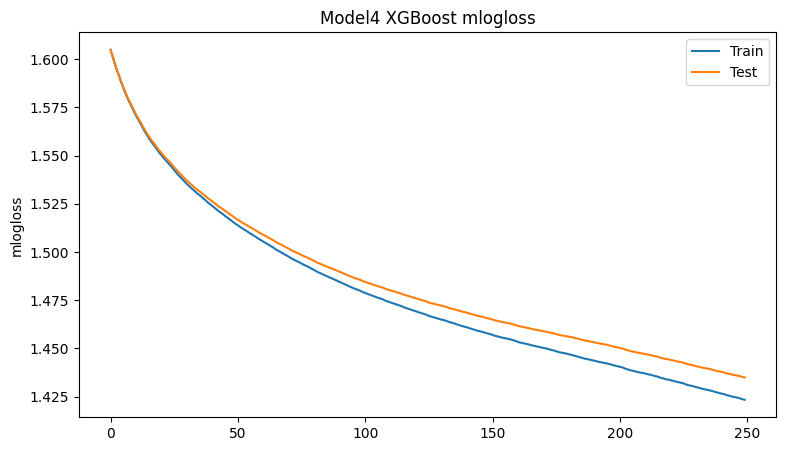

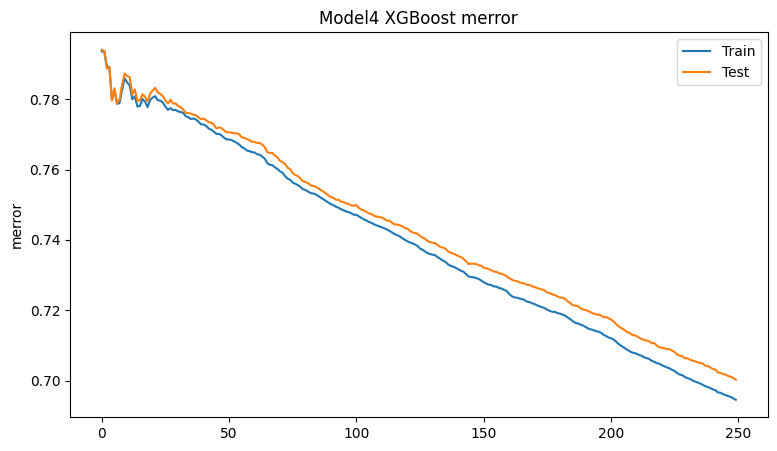

In [62]:
# preparing evaluation metric plots
results = best_modelg.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model4 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model4 XGBoost merror')
plt.show()

In [64]:
y_predg = best_modelg.predict(X_testx)
from sklearn.metrics import classification_report, confusion_matrix
print("Matriz de Confusión:\n", confusion_matrix(y_testx, y_predg))
print("Reporte de Clasificación:\n", classification_report(y_testx, y_predg))

Matriz de Confusión:
 [[10653  3106  6860  2911  3940]
 [ 2287  3287  2207  1306  3080]
 [   19     5    46     6     6]
 [ 4610  2932  4312  2837  3134]
 [  208   150   304    80   919]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.60      0.39      0.47     27470
           1       0.35      0.27      0.30     12167
           2       0.00      0.56      0.01        82
           3       0.40      0.16      0.23     17825
           4       0.08      0.55      0.14      1661

    accuracy                           0.30     59205
   macro avg       0.29      0.39      0.23     59205
weighted avg       0.47      0.30      0.35     59205



In [65]:
best_paramsGG = {
    'colsample_bynode': 0.5,
    'gamma': 0.5,
    'learning_rate': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 250,  # Updated n_estimators to 250 as per your original parameters
    'subsample': 1.0,  # Updated subsample to 1.0
    'booster': 'gbtree',
    'max_delta_step': 2,
    'eval_metric': ['merror','mlogloss'],  
    'max_leaves': 20,
    'max_bin': 1024,  # Updated max_bin to 1024
    'alpha': 1,  # Updated alpha to 1
    'lambda': 1,
    'num_class': 5,
}

best_modelgg = XGBClassifier(tree_method='gpu_hist', **best_paramsGG)
best_modelgg.fit(X_trainx, y_trainx, eval_set=[(X_trainx, y_trainx), (X_testx, y_testx)], verbose=0)

XGBClassifier(alpha=1, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.5,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.05, max_bin=1024, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=2, max_depth=10,
              max_leaves=20, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_class=5, ...)

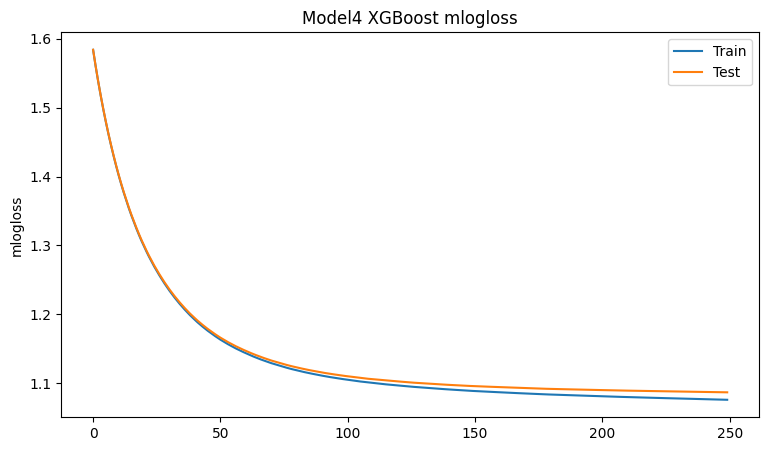

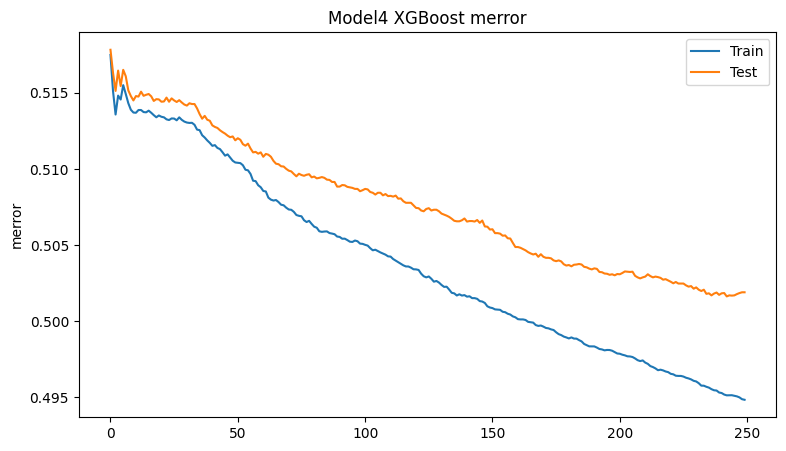

In [66]:
# preparing evaluation metric plots
results = best_modelgg.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('Model4 XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('Model4 XGBoost merror')
plt.show()

In [76]:
results['validation_0']['merror']

[0.5174861495844876,
 0.5151045537463685,
 0.5135759408148098,
 0.5148174109857442,
 0.5145598270387136,
 0.5155057090737112,
 0.5149272008648065,
 0.514319133842308,
 0.5138884197013716,
 0.5137068441321533,
 0.5136899533815282,
 0.5138715289507466,
 0.5138715289507466,
 0.513736402945747,
 0.5137195121951219,
 0.5138293020741842,
 0.5136899533815282,
 0.5135337139382474,
 0.5133943652455916,
 0.5135126004999662,
 0.5134281467468415,
 0.5133901425579352,
 0.5132592392405918,
 0.5132127896763732,
 0.5133183568677792,
 0.5133099114924667,
 0.5131958989257482,
 0.5133901425579352,
 0.5132254577393419,
 0.5131114451726235,
 0.5130481048577799,
 0.5130227687318425,
 0.5130312141071549,
 0.5129003107898115,
 0.5125836092155935,
 0.5125498277143437,
 0.5122162353895007,
 0.5120642186338761,
 0.5118741976893453,
 0.5117137355584083,
 0.5115194919262211,
 0.5115659414904399,
 0.5113801432335653,
 0.511304134855753,
 0.5110972231605972,
 0.5108734207148166,
 0.5109578744679414,
 0.5107467400851

In [67]:
y_predgg = best_modelgg.predict(X_testx)
from sklearn.metrics import classification_report, confusion_matrix
print("Matriz de Confusión:\n", confusion_matrix(y_testx, y_predgg))
print("Reporte de Clasificación:\n", classification_report(y_testx, y_predgg))

Matriz de Confusión:
 [[24547  1303     0  1620     0]
 [ 8170  2585     0  1412     0]
 [   76     3     0     3     0]
 [13748  1719     0  2358     0]
 [ 1155   279     0   227     0]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.51      0.89      0.65     27470
           1       0.44      0.21      0.29     12167
           2       0.00      0.00      0.00        82
           3       0.42      0.13      0.20     17825
           4       0.00      0.00      0.00      1661

    accuracy                           0.50     59205
   macro avg       0.27      0.25      0.23     59205
weighted avg       0.46      0.50      0.42     59205



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


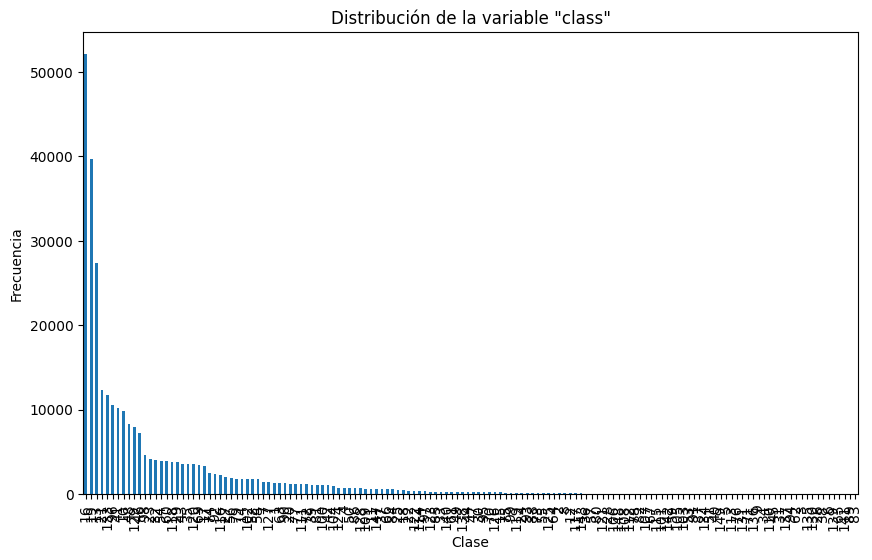

    Clase  Frecuencia
0      16       52114
1      19       39637
2      13       27367
3      21       12337
4     133       11740
..    ...         ...
139   139           7
140    65           7
141   141           5
142    89           5
143    83           1

[144 rows x 2 columns]


In [74]:
# Gráfico de barras para visualizar la distribución de clases
plt.figure(figsize=(10, 6))
poke['class'].value_counts().plot(kind='bar')
plt.title('Distribución de la variable "class"')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

pd.set_option('display.max_rows', 10)
# Tabla de frecuencia de clases
class_counts = poke['class'].value_counts().reset_index()
class_counts.columns = ['Clase', 'Frecuencia']
print(class_counts)

In [71]:
import cudf
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC
#from cuml.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix
# Crear DataFrames cuDF para almacenar los datos
X_train_cudf = cudf.DataFrame.from_pandas(X_train)
X_test_cudf = cudf.DataFrame.from_pandas(X_test)
y_train_cudf = cudf.Series(y_train)
y_test_cudf = cudf.Series(y_test)

# Crear diccionarios para almacenar los modelos y sus predicciones
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()
}
predictions = {}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    # Entrenar el modelo en los datos de entrenamiento
    model.fit(X_train_cudf, y_train_cudf)

    # Realizar predicciones en el conjunto de prueba
    y_pred_cudf = model.predict(X_test_cudf)
    y_pred = y_pred_cudf.to_pandas().values  # Convertir a NumPy array
    predictions[model_name] = y_pred

    # Calcular y mostrar el informe de clasificación (utilizando scikit-learn)
    report = classification_report(y_test_cudf.to_pandas().values, y_pred)
    print(f"{model_name} - Classification Report:\n{report}\n")

    # Calcular y mostrar la matriz de confusión (utilizando scikit-learn)
    confusion = confusion_matrix(y_test_cudf.to_pandas().values, y_pred)
    print(f"{model_name} - Confusion Matrix:\n{confusion}\n")

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.97      0.63     27470
           1       0.30      0.00      0.00     12167
           2       0.00      0.00      0.00        82
           3       0.36      0.04      0.08     17825
           4       0.00      0.00      0.00      1661

    accuracy                           0.46     59205
   macro avg       0.23      0.20      0.14     59205
weighted avg       0.39      0.46      0.32     59205


Logistic Regression - Confusion Matrix:
[[26680    25     0   765     0]
 [11637    21     0   509     0]
 [   81     0     0     1     0]
 [17013    22     0   790     0]
 [ 1543     3     0   115     0]]



/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.84      0.66     27470
           1       0.45      0.23      0.31     12167
           2       0.00      0.00      0.00        82
           3       0.42      0.23      0.29     17825
           4       0.41      0.02      0.04      1661

    accuracy                           0.51     59205
   macro avg       0.36      0.26      0.26     59205
weighted avg       0.48      0.51      0.46     59205


Random Forest - Confusion Matrix:
[[23189  1276     0  2998     7]
 [ 6966  2813     0  2351    37]
 [   70     4     0     8     0]
 [12068  1730     0  4018     9]
 [  929   394     0   301    37]]

KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.72      0.61     27470
           1       0.33      0.26      0.29     12167
           2       0.00      0.00      0.00        82
           3       0.36 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
X_train_cudfx = cudf.DataFrame.from_pandas(X_trainx)
X_test_cudfx = cudf.DataFrame.from_pandas(X_testx)
y_train_cudfx = cudf.Series(y_trainx)
y_test_cudfx = cudf.Series(y_testx)

# Crear diccionarios para almacenar los modelos y sus predicciones
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()
}
predictions = {}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    # Entrenar el modelo en los datos de entrenamiento
    model.fit(X_train_cudfx, y_train_cudfx)

    # Realizar predicciones en el conjunto de prueba
    y_pred_cudfx = model.predict(X_test_cudfx)
    y_predxx = y_pred_cudfx.to_pandas().values  # Convertir a NumPy array
    predictions[model_name] = y_predx

    # Calcular y mostrar el informe de clasificación (utilizando scikit-learn)
    report = classification_report(y_test_cudfx.to_pandas().values, y_predxx)
    print(f"{model_name} - Classification Report:\n{report}\n")

    # Calcular y mostrar la matriz de confusión (utilizando scikit-learn)
    confusion = confusion_matrix(y_test_cudfx.to_pandas().values, y_predxx)
    print(f"{model_name} - Confusion Matrix:\n{confusion}\n")

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decor

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.97      0.63     27470
           1       0.28      0.00      0.00     12167
           2       0.00      0.00      0.00        82
           3       0.36      0.05      0.08     17825
           4       0.00      0.00      0.00      1661

    accuracy                           0.46     59205
   macro avg       0.22      0.20      0.14     59205
weighted avg       0.38      0.46      0.32     59205


Logistic Regression - Confusion Matrix:
[[26676    13     0   781     0]
 [11645    11     0   511     0]
 [   81     0     0     1     0]
 [17007    15     0   803     0]
 [ 1545     1     0   115     0]]



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.85      0.66     27470
           1       0.45      0.23      0.31     12167
           2       0.00      0.00      0.00        82
           3       0.42      0.21      0.28     17825
           4       0.40      0.02      0.04      1661

    accuracy                           0.51     59205
   macro avg       0.36      0.26      0.26     59205
weighted avg       0.48      0.51      0.45     59205


Random Forest - Confusion Matrix:
[[23393  1275     0  2795     7]
 [ 7100  2805     0  2226    36]
 [   71     4     0     7     0]
 [12296  1716     0  3801    12]
 [  932   394     0   298    37]]

KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.72      0.61     27470
           1       0.33      0.26      0.29     12167
           2       0.00      0.00      0.00        82
           3       0.36 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
